In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics

## DATA100 S12

### GROUP 1 MEMBERS:
#### Ardales, Darius Vincent C.
#### Pe, Steven Daniel T.
#### Siababa, Aubrei Gould R.
#### Yao, Zeyao
#### Yu, John Xavier T.

# 1. Adjust the price of the product based on the CPI
## 1.1 Computing for the CPI per region per year based on the GRDP data

In [ ]:
# Import GRDP data
GRDP = pd.read_csv('GROSS REGIONAL DOMESTIC PRODUCT.csv')

# Create an empty dataframe for storing the CPI of each region by year with 2018 as the reference
CPI = pd.DataFrame({
    '2010':[],
    '2011':[],
    '2012':[],
    '2013':[],
    '2014':[],
    '2015':[],
    '2016':[],
    '2017':[],
    '2018':[],
    '2019':[],
    '2020':[],
    '2021':[],
    '2022':[],
})

# Calculate for the consumer price index (CPI) based on 2018 price
for col in CPI.columns:
    CPI[col] = (GRDP['At Constant 2018 Prices ' + str(col)]/GRDP['At Constant 2018 Prices ' + str(2018)])*100

# Replace the label for the ARMM region in GRDP to fit the format of the wholesale data
GRDP.loc[16,'Region'] = '..AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)'

# Add the region to be part of CPI and make it the index
CPI['Region'] = GRDP['Region'].str.upper()
CPI.set_index('Region', inplace = True)

## 1.2 Adjust the price

In [ ]:
# A function that adjusts all the wholesale prices based on the computed CPI based on 2018
def adjust(csv):
    # Import the file
    data = pd.read_csv(csv)

    # Rename the columns
    for col in data.columns:
        if col not in ['Geolocation', 'Commodity']:
            new_col = col.replace(' Annual', '')
            data.rename(columns={col: new_col}, inplace=True)
            # Adjust the data type for the price columns to be numeric, and the missing values will be replaced with NaN
            data[new_col] = pd.to_numeric(data[new_col], errors='coerce')

    # Create a loop that will divide each price with the appropirate CPI based on the year and the region it is in
    for index, row in data.iterrows():
        reg = row['Geolocation']
        for col in CPI.columns:
            row[str(col)] = row[str(col)]/CPI[str(col)][reg]
            data.loc[index, str(col)] /= CPI[str(col)][reg]/100

    # The output will be the adjusted dataset
    return data

## 1.3 Apply the adjust() function

In [ ]:
# Adjusted data for BEANS AND LEGUMES ANNUAL.csv
adjusted_BeanAndLegumes = adjust('BEANS AND LEGUMES ANNUAL.csv')

# Adjusted data for CEREALS ANNUAL.csv
adjusted_Cereals = adjust('CEREALS ANNUAL.csv')

# Adjusted data for COMMERCIAL CROPS ANNUAL.csv
adjusted_CommercialCrops = adjust('COMMERCIAL CROPS ANNUAL.csv')

# Adjusted data for CONDIMENTS ANNUAL.csv
adjusted_Condiments = adjust('CONDIMENTS ANNUAL.csv')

# Adjusted data for FRUIT VEGETABLES ANNUAL.csv
adjusted_FruitVegetables = adjust('FRUIT VEGETABLES ANNUAL.csv')

# Adjusted data for FRUITS ANNUAL.csv
adjusted_Fruits = adjust('FRUITS ANNUAL.csv')

# Adjusted data for LEAFY VEGETABLES ANNUAL.csv
adjusted_LeafyVegetables = adjust('LEAFY VEGETABLES ANNUAL.csv')

# Adjusted data for POULTRY ANNUAL.csv
adjusted_Poultry = adjust('POULTRY ANNUAL.csv')

# Adjusted data for ROOTCROPS ANNUAL.csv
adjusted_Rootcrops = adjust('ROOTCROPS ANNUAL.csv')

# Adjusted data for SEAFOOD ANNUAL.csv
adjusted_Seafood = adjust('SEAFOOD ANNUAL.csv')

# 2. Clean up missing values in annual wholesale goods data

### Impute for the missing prices given there are less than or equal to 3 missing values only

## 2.1 Subfunctions to be placed in 2.2 that focuses on imputing prices with different senarios

In [ ]:
# A function that imputes the price if there is no reference price before it
def earliest(year,data,i):
    col_n = str(int(year)+1) # Next year column
    col_nn = str(int(year)+2) # Next next year column
    d = (data.loc[i,col_nn]-data.loc[i,col_n])/data.loc[i,col_n] # Percent increase in price from the next to the next next year
    # Calculates the missing prices assuming the same amount of price increase from the missing year to the year after
    data.loc[i, year] = data.loc[i,col_n]/(1+d)

# A function that imputes the price if there is no reference point after it
def latest(year,data,i):
    col_l = str(int(year)-1) # Last year column
    col_ll = str(int(year)-2) # Last last year column
    d = (data.loc[i,col_l]-data.loc[i,col_ll])/data.loc[i,col_ll] # Percent increase in price from the last last to the last next year
    # Calculates the missing prices assuming the same amount of price increase from last year to the missing year
    data.loc[i, year] = data.loc[i,col_l]*(1+d)

# A function that imputes using the average of the neighboring cells
def middle(year,data,i):
    col_l = str(int(year)-1) # Last year column
    col_n = str(int(year)+1) # Next year column
    # Calculates the missing prices by getting the average from the neighbor
    data.loc[i, year] = (data.loc[i, col_l]+data.loc[i,col_n])/2

# A function that imputes by getting the trisection points
def two_middle(year1,year2,data,i):
    col_l = str(int(year1)-1) # Last year column
    col_n = str(int(year2)+1) # Next year column
    # Calculates the first missing price with the first trisecting point
    data.loc[i,year1] = data.loc[i,col_l]+(1/3)*(data.loc[i,col_l]+data.loc[i,col_n])
    # Calculates the second missing price with the first trisecting point
    data.loc[i,year2] = data.loc[i,col_l]+(2/3)*(data.loc[i,col_l]+data.loc[i,col_n])

# A function that imputes by getting the quarter points
def three_middle(year1,year2,year3,data,i):
    col_l = str(int(year1)-1) # Last year column
    col_n = str(int(year3)+1) # Next year column
    # Calculates the first missing price with the first trisecting point
    data.loc[i,year1] = data.loc[i,col_l]+(1/4)*(data.loc[i,col_l]+data.loc[i,col_n])
    # Calculates the second missing price with the first trisecting point
    data.loc[i,year2] = data.loc[i,col_l]+(1/2)*(data.loc[i,col_l]+data.loc[i,col_n])
    # Calculates the third missing price with the first trisecting point
    data.loc[i,year3] = data.loc[i,col_l]+(3/4)*(data.loc[i,col_l]+data.loc[i,col_n])

## 2.2 Function that lists all possible arrangements of the 3 missing values and imputes using the functions in 2.1, the rows with more than 3 missings are dropped

In [ ]:
# A function that filters out or impute for the adjusted price of the product each year
def fil_impute(data):
    for index, row in data.iterrows():
        nan_ind = []
        nan_cols = row.index[row.isnull()].tolist()
        nan_ind.append((index, nan_cols))
        # Create a list that contains the columns with NaN value in this row
        nan_list = nan_ind[0][1]

# If there are more than 3 missing values, drop it
        if len(nan_list) > 3:
            data.drop(index,inplace = True)
# If there is only one missing price
        elif len(nan_list) == 1:
            Y1 = nan_list[0] # Simplify the 1st year with NaN val
            if Y1 == '2010': # If the earliest data is missing
                earliest(Y1,data,index)
            elif Y1 == '2022': # If the latest data is missing
                latest(Y1,data,index)
            else: # If the missing data is in the middle
                middle(Y1,data,index)

# If there are 2 missing prices
        elif len(nan_list) == 2:
            Y1 = nan_list[0] # Simplify the 1st year with NaN val
            Y2 = nan_list[1] # Simplify the 2nd year with NaN val
            if Y1 == '2010': # If the earliest data is missing
                if Y2 == '2011': # If the data next to the earliest year is also missing, then prioritize this one
                    earliest(Y2,data,index)
                    earliest(Y1,data,index)
                elif Y2 == '2022':
                    latest(Y2,data,index)
                    earliest(Y1,data,index)
                else:
                    middle(Y2,data,index)
                    earliest(Y1,data,index)
            elif Y2 == '2022': # If the lastest data is missing
                if Y1 == '2021': # If 2nd to the last data is also missing
                    latest(Y1,data,index)
                    latest(Y2,data,index)
                else: # If the 1st missing data isn't right next to the 2nd
                    latest(Y2,data,index)
                    middle(Y1,data,index)
            else: # If none of the head or tail price is missing
                if int(Y2) == int(Y1)+1: #if the two data are right next to each other
                    two_middle(Y1,Y2,data,index)
                else:
                    middle(Y1,data,index)
                    middle(Y2,data,index)

# If there are 3 missing prices
        elif len(nan_list) == 3:
            Y1 = nan_list[0] # Simplify the 1st year with NaN val
            Y2 = nan_list[1] # Simplify the 2nd year with NaN val
            Y3 = nan_list[-1] # Simplify the 3rd year with NaN val
            if Y1 == '2010': # If the earliest data is missing
                if Y2 == '2011':
                    if Y3 == '2012':# If the first 3 values are missing
                        earliest(Y3,data,index)
                        earliest(Y2,data,index)
                        earliest(Y1,data,index)
                    elif Y3 == '2022': # If the first two are next to each other, but the 3rd is last
                        latest(Y3,data,index)
                        earliest(Y2,data,index)
                        earliest(Y1,data,index)
                    else:
                        middle(Y3,data,index)
                        earliest(Y2,data,index)
                        earliest(Y1,data,index)
                elif Y3 == '2022':
                    if Y2 == '2021': # If the last two are next to each other
                        latest(Y3,data,index)
                        latest(Y2,data,index)
                        earliest(Y1,data,index)
                    else:
                        latest(Y3,data,index)
                        middle(Y2,data,index)
                        earliest(Y1,data,index)
            elif Y3 == '2022': # If the last is missing
                if Y1 == '2020': # If all the 3 are the last's
                    latest(Y1,data,index)
                    latest(Y2,data,index)
                    latest(Y3,data,index)
                elif Y2 == '2021': # If the last two missing values are next to each other
                    latest(Y2,data,index)
                    latest(Y3,data,index)
                    middle(Y1,data,index)
                elif int(Y2) == int(Y1)+1: # If the 1st and 2nd are next to each other
                    two_middle(Y1,Y2,data,index)
                    latest(Y3,data,index)
            elif int(Y2) == int(Y1)+1: # If the 1st and 2nd are next to each other
                if int(Y3) == int(Y2)+1: # If all the 3 are next to each other
                    three_middle(Y1,Y2,Y3,data,index)
                else: # If third is not the last
                    two_middle(Y1,Y2,data,index)
                    middle(Y3,data,index)
            elif int(Y3) == int(Y2)+1: # If the 2nd and the 3rd are next to each other
                if Y1 == '2010': # If the 1st is the 1st missing
                    earliest(Y1,data,index)
                    two_middle(Y2,Y3,data,index)
                else: # If the 1st isn't the 1st missing year
                    middle(Y1,data,index)
                    two_middle(Y2,Y3,data,index)

    return data

## 2.3 Applying the data cleaning and imputation to all wholesale dataset

In [ ]:
# Filtered data for BEANS AND LEGUMES ANNUAL.csv
cleaned_BeanAndLegumes = fil_impute(adjusted_BeanAndLegumes)

# Filtered data for CEREALS ANNUAL.csv
cleaned_Cereals = fil_impute(adjusted_Cereals)

# Filtered  data for COMMERCIAL CROPS ANNUAL.csv
cleaned_CommercialCrops = fil_impute(adjusted_CommercialCrops)

# Filtered data for CONDIMENTS ANNUAL.csv
cleaned_Condiments = fil_impute(adjusted_Condiments)

# Filtered data for FRUIT VEGETABLES ANNUAL.csv
cleaned_FruitVegetables = fil_impute(adjusted_FruitVegetables)

# Filtered data for FRUITS ANNUAL.csv
cleaned_Fruits = fil_impute(adjusted_Fruits)

# Filtered data for LEAFY VEGETABLES ANNUAL.csv
cleaned_LeafyVegetables = fil_impute(adjusted_LeafyVegetables)

# Filtered data for POULTRY ANNUAL.csv
cleaned_Poultry = fil_impute(adjusted_Poultry)

# Filtered data for ROOTCROPS ANNUAL.csv
cleaned_Rootcrops = fil_impute(adjusted_Rootcrops)

# Filtered data for SEAFOOD ANNUAL.csv
cleaned_Seafood = fil_impute(adjusted_Seafood)

# 3. Generating GRDP per capita features using the GRDP dataset and census dataset
## 3.1 Preparing the census dataset

In [ ]:
# Import census population data by region
census = pd.read_csv("CENSUS POPULATION BY REGION.csv")
census.head()

Geographic Location      2010      2015      2020
0           ..NATIONAL CAPITAL REGION (NCR)  11855975  12877253  13484462
1  ..CORDILLERA ADMINISTRATIVE REGION (CAR)   1616867   1722006   1797660
2                ..REGION I (ILOCOS REGION)   4748372   5026128   5301139
3              ..REGION II (CAGAYAN VALLEY)   3229163   3451410   3685744
4              ..REGION III (CENTRAL LUZON)  10137737  11218177  12422172

#### As observed in the dataset, columns are available for the years 2010, 2015, and 2020. However, we need to include data for the years 2010 to 2022. To achieve this, new columns will be created for the missing years (2011 through 2014, 2016 through 2019, and 2021-2022), and their corresponding observations will be set to NaN.

In [ ]:
# Use Geographical Location as index first so it won't be included in the reindexing
census.set_index('Geographic Location', inplace=True)

# Create list of column names for years 2010-2022
years = [str(year) for year in range(2010, 2023)]

# Reindex the census data to include all years and fill missing values with NaN
new_census = census.reindex(columns=years, fill_value=None)
new_census.reset_index(inplace=True)
new_census.head()

Geographic Location      2010  2011  2012  2013  2014  \
0           ..NATIONAL CAPITAL REGION (NCR)  11855975   NaN   NaN   NaN   NaN   
1  ..CORDILLERA ADMINISTRATIVE REGION (CAR)   1616867   NaN   NaN   NaN   NaN   
2                ..REGION I (ILOCOS REGION)   4748372   NaN   NaN   NaN   NaN   
3              ..REGION II (CAGAYAN VALLEY)   3229163   NaN   NaN   NaN   NaN   
4              ..REGION III (CENTRAL LUZON)  10137737   NaN   NaN   NaN   NaN   

       2015  2016  2017  2018  2019      2020  2021  2022  
0  12877253   NaN   NaN   NaN   NaN  13484462   NaN   NaN  
1   1722006   NaN   NaN   NaN   NaN   1797660   NaN   NaN  
2   5026128   NaN   NaN   NaN   NaN   5301139   NaN   NaN  
3   3451410   NaN   NaN   NaN   NaN   3685744   NaN   NaN  
4  11218177   NaN   NaN   NaN   NaN  12422172   NaN   NaN

#### Upon reviewing the dataset, we have introduced new columns for each year spanning from 2010 to 2022. To facilitate analysis and visualization, we intend to transform these columns into observations by MELTING the year columns, organizing the data based on geographical locations.

In [ ]:
years = [str(year) for year in range(2010, 2023)]
# Melt the census to transform year columns into observations based on the Geographic Location
melted_census = new_census.melt(id_vars = ['Geographic Location'], value_vars = years, var_name='Year', value_name='Population')
print("-------- Null Values --------")
melted_census.isna().sum()

-------- Null Values --------


Geographic Location      0
Year                     0
Population             170
dtype: int64

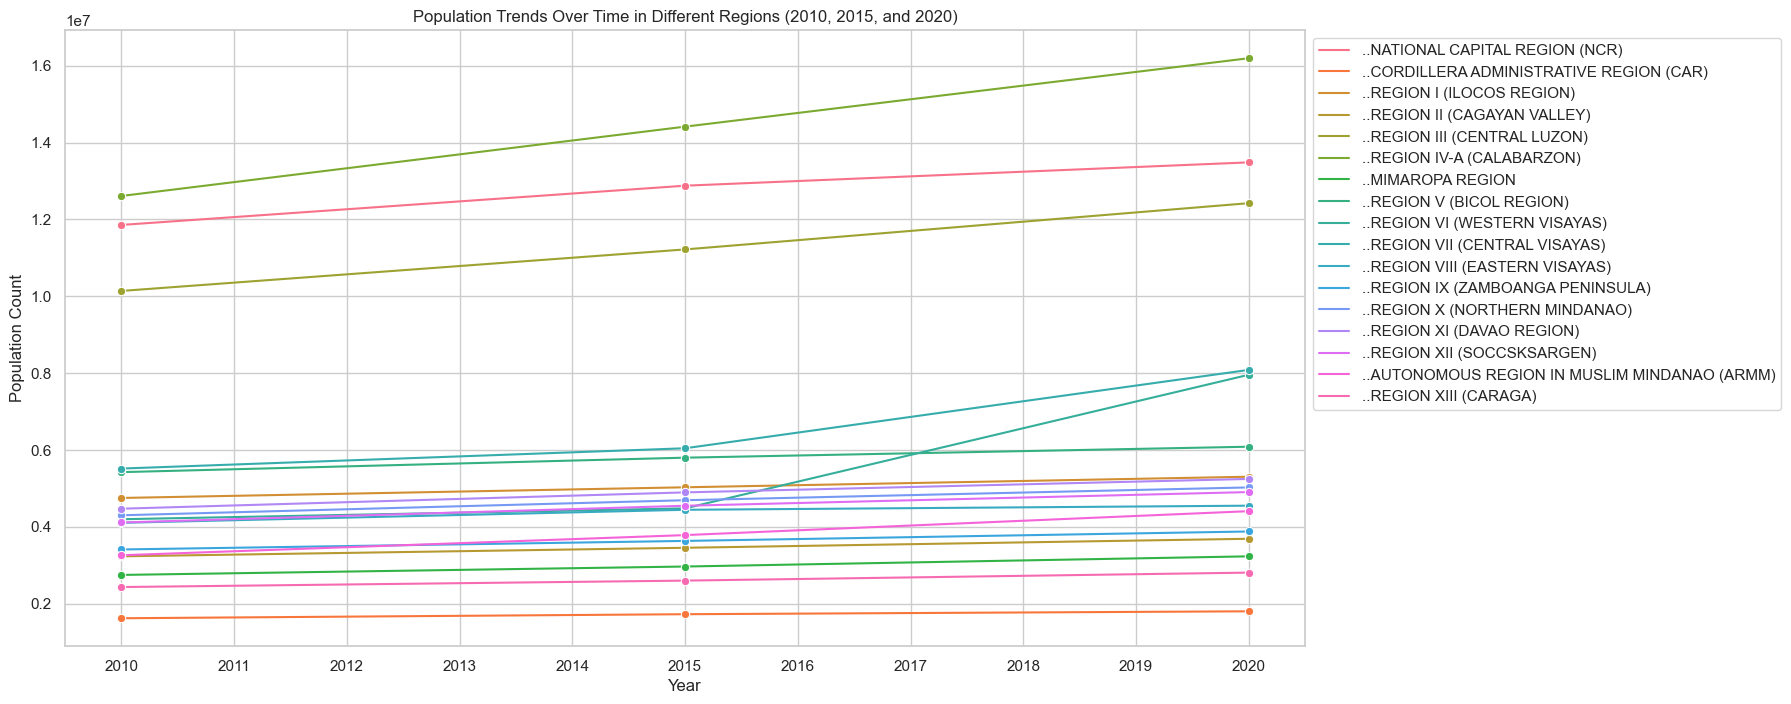

In [ ]:
# Plot the population over time per region
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

g = sns.lineplot(data=melted_census, x='Year', y='Population', hue='Geographic Location', marker='o')

g.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title("Population Trends Over Time in Different Regions (2010, 2015, and 2020)")
plt.xlabel("Year")
plt.ylabel("Population Count")
plt.show()

#### As evident from the line plot presented above, the population growth per region for the years 2010, 2015, and 2020 (with other years disregarded due to NaN values) demonstrates a positive linear trend. This observation suggests the potential for imputing missing values for other years through the application of LINEAR INTERPOLATION.

In [ ]:
# Convert year column from type object to type int
melted_census['Year'] = melted_census['Year'].astype(int)

# Ensure that the melted_census is sorted by Geographic Location and Year for better interpolation (Will reset this after interpolation)
melted_census = melted_census.sort_values(['Geographic Location', 'Year'])

# Group by 'Geographic Location' and apply linear interpolation to the 'Population' column within each group
melted_census['Population'] = melted_census.groupby('Geographic Location', group_keys=False)['Population'].apply(lambda region: region.interpolate(method='linear'))

# Reset the sorting order
melted_census = melted_census.sort_index()

print("-------- Null Values --------")
melted_census.isna().sum()

-------- Null Values --------


Geographic Location    0
Year                   0
Population             0
dtype: int64

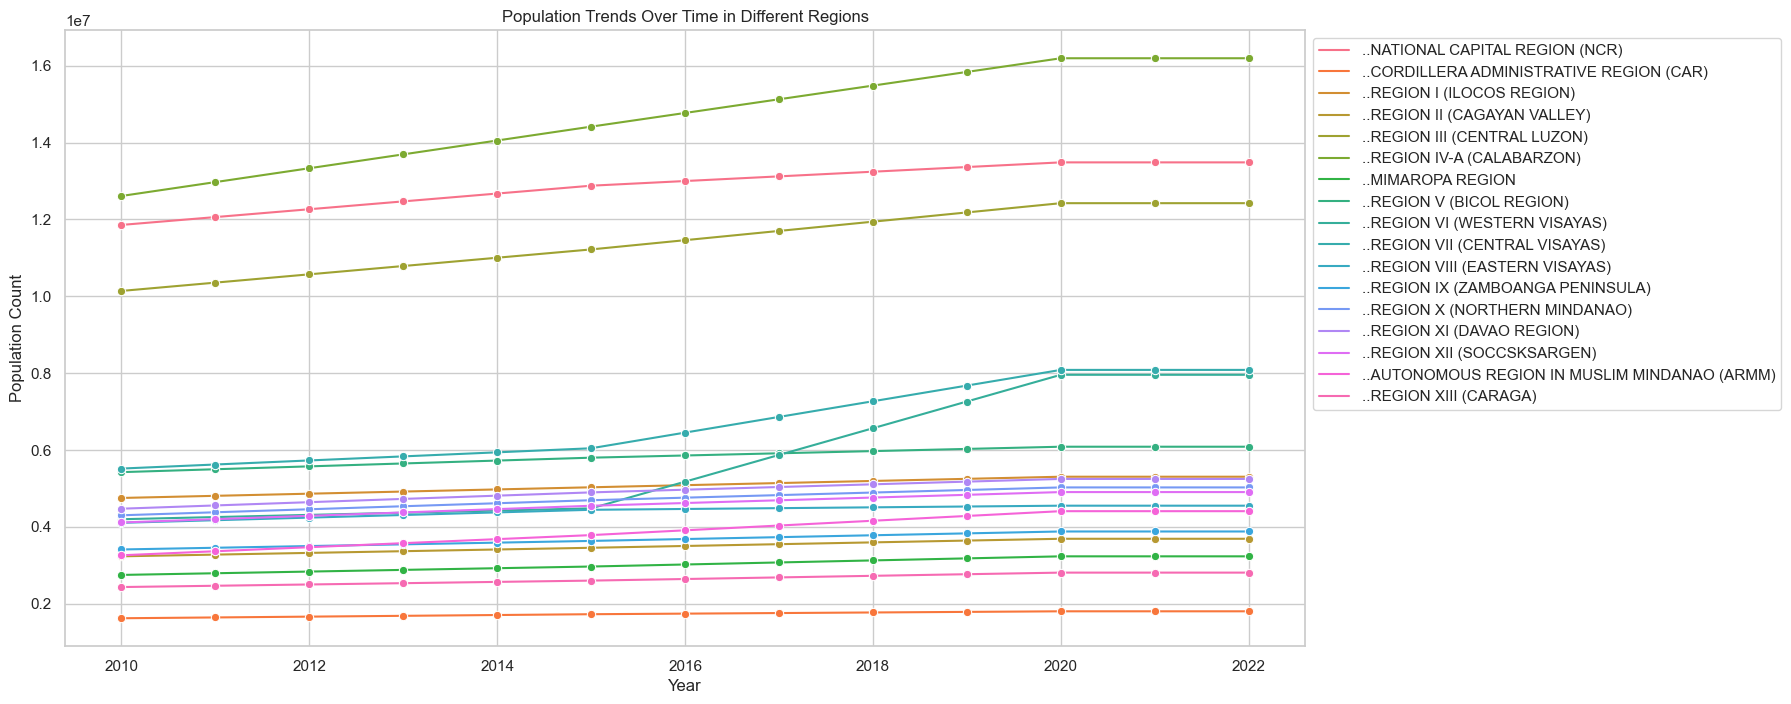

In [ ]:
#plot the population over time per region
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

g = sns.lineplot(data=melted_census, x='Year', y='Population', hue='Geographic Location', marker='o')

g.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title("Population Trends Over Time in Different Regions")
plt.xlabel("Year")
plt.ylabel("Population Count")
plt.show()

In [ ]:
# Revert the melted census back to it's original format where years are columns by using pivot
reverted_census = melted_census.pivot(index='Geographic Location', columns='Year', values='Population').reset_index()
# DONE PREPARING THE CENSUS DATASET

## 3.2 Calculate GRDP per capita

#### To calculate the GRDP per capita, we merge the census dataset with the GRDP dataset. Subsequently, we reconfigure the dataset to enhance readability.

In [ ]:
# Capitalize Region names in GRDP
GRDP['Region'] = GRDP["Region"].str.upper()

# Do a one-to-one merge on the GRDP and census datasets based on their region
GRDP_census = reverted_census.merge(GRDP, left_on ='Geographic Location', right_on='Region')

# Drop the redundant column
GRDP_census.drop(columns='Geographic Location', inplace=True)

# Rename columns for more readability
columns_to_rename = {2010: 'Population_2010', 2011: 'Population_2011', 2012: 'Population_2012', 2013: 'Population_2013',
                     2014: 'Population_2014', 2015: 'Population_2015', 2016: 'Population_2016', 2017: 'Population_2017',
                     2018: 'Population_2018', 2019: 'Population_2019', 2020: 'Population_2020', 2021: 'Population_2021',
                     2022: 'Population_2022',
                     }
GRDP_census.rename(columns=columns_to_rename, inplace=True)

# Rearrange columns so that region is shown in the first column
years = [str(year) for year in range(2010,2023)]
population_years = [f'Population_{year}' for year in years]

# Rearranging part
rearranged_columns = ['Region'] + population_years
no_change_columns = list(GRDP_census.columns[len(rearranged_columns):])
GRDP_census = GRDP_census[rearranged_columns + no_change_columns]

# Change data type of populations per year from float to int
for population in population_years:
  GRDP_census[str(population)] = GRDP_census[str(population)].astype(int)

#### After organizing and enhancing the readability of the merged dataset, we add columns that compute the GRDP per capita based on the year.

In [ ]:
# Initialize the years
years = [str(year) for year in range(2010,2023)]

# Loop through the years to calculate GRDP per capita for each region by year
for year in years:
  GRDP_census['GRDP per Capita '+ year] = GRDP_census['At Current Prices ' + year] / GRDP_census['Population_' + year]

GRDP_census.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 16
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Region                        17 non-null     object 
 1   Population_2010               17 non-null     int32  
 2   Population_2011               17 non-null     int32  
 3   Population_2012               17 non-null     int32  
 4   Population_2013               17 non-null     int32  
 5   Population_2014               17 non-null     int32  
 6   Population_2015               17 non-null     int32  
 7   Population_2016               17 non-null     int32  
 8   Population_2017               17 non-null     int32  
 9   Population_2018               17 non-null     int32  
 10  Population_2019               17 non-null     int32  
 11  Population_2020               17 non-null     int32  
 12  Population_2021               17 non-null     int32  
 13  Populat

In [ ]:
# For regression purposes, we only need the GRDP and GRDP per Capita Columns
# The indices are dropped for ease of adding dataframes later on

GRDP_percapita = GRDP_census.loc[:, ['Region'] + list(GRDP_census.loc[:,'GRDP per Capita 2010':'GRDP per Capita 2022'])]
GRDP_percapita.set_index('Region',inplace=True)
GRDP_percapita = GRDP_percapita.transpose()
GRDP_percapita.reset_index(drop=True, inplace=True)

GRDPs = GRDP_census.loc[:, ['Region'] + list(GRDP_census.loc[:,'At Constant 2018 Prices 2010':'At Constant 2018 Prices 2022'])]
GRDPs.set_index('Region',inplace=True)
GRDPs = GRDPs.transpose()

GRDPs.reset_index(drop=True, inplace=True)
GRDPs


Region  ..AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)  \
0                                           161737153   
1                                           166414758   
2                                           170707107   
3                                           178542938   
4                                           189848311   
5                                           191818068   
6                                           198444393   
7                                           218512906   
8                                           235393060   
9                                           249157465   
10                                          244524738   
11                                          262884259   
12                                          280267304   

Region  ..CORDILLERA ADMINISTRATIVE REGION (CAR)  ..MIMAROPA REGION  \
0                                      220343710          232547423   
1                                      221420475          241561347   
2                                      221950621          254595082   
3                                      236871362          265363628   
4                                      248982342          292033215   
5                                      259526063          305952533   
6                                      266691916          321170118   
7                                      291775205          341505717   
8                                      308267122          370744808   
9                                      321722276          386783632   
10                                     288876582          357780630   
11                                     310765858          369725008   
12                                     337664054          392960370   

Region  ..NATIONAL CAPITAL REGION (NCR)  ..REGION I (ILOCOS REGION)  \
0                            3745124533                   364366356   
1                            3833040760                   378621382   
2                            4072189800                   398616600   
3                            4339858704                   432692177   
4                            4576914911                   461217885   
5                            4865073608                   486062080   
6                            5216091453                   525389666   
7                            5507681038                   554680762   
8                            5814440130                   587597251   
9                            6224134457                   630362667   
10                           5599931197                   581877977   
11                           5845619151                   608618834   
12                           6265608932                   654866006   

Region  ..REGION II (CAGAYAN VALLEY)  ..REGION III (CENTRAL LUZON)  \
0                          232748963                    1143777786   
1                          247587301                    1233431610   
2                          264876624                    1336963348   
3                          288512422                    1417025690   
4                          312814849                    1526621058   
5                          325728274                    1619134911   
6                          341540501                    1747565400   
7                          368250759                    1929193858   
8                          385061271                    2062393875   
9                          411513567                    2183779631   
10                         371102979                    1881277315   
11                         389954561                    2021186175   
12                         421171436                    2185061752   

Region  ..REGION IV-A (CALABARZON)  ..REGION IX (ZAMBOANGA PENINSULA)  \
0                       1638482343                          239770872   
1                       1676719329                          240130505   
2          

# 4. Exploratory Data Analysis

## 4.1 Line graph of  Average Price of Goods by Region

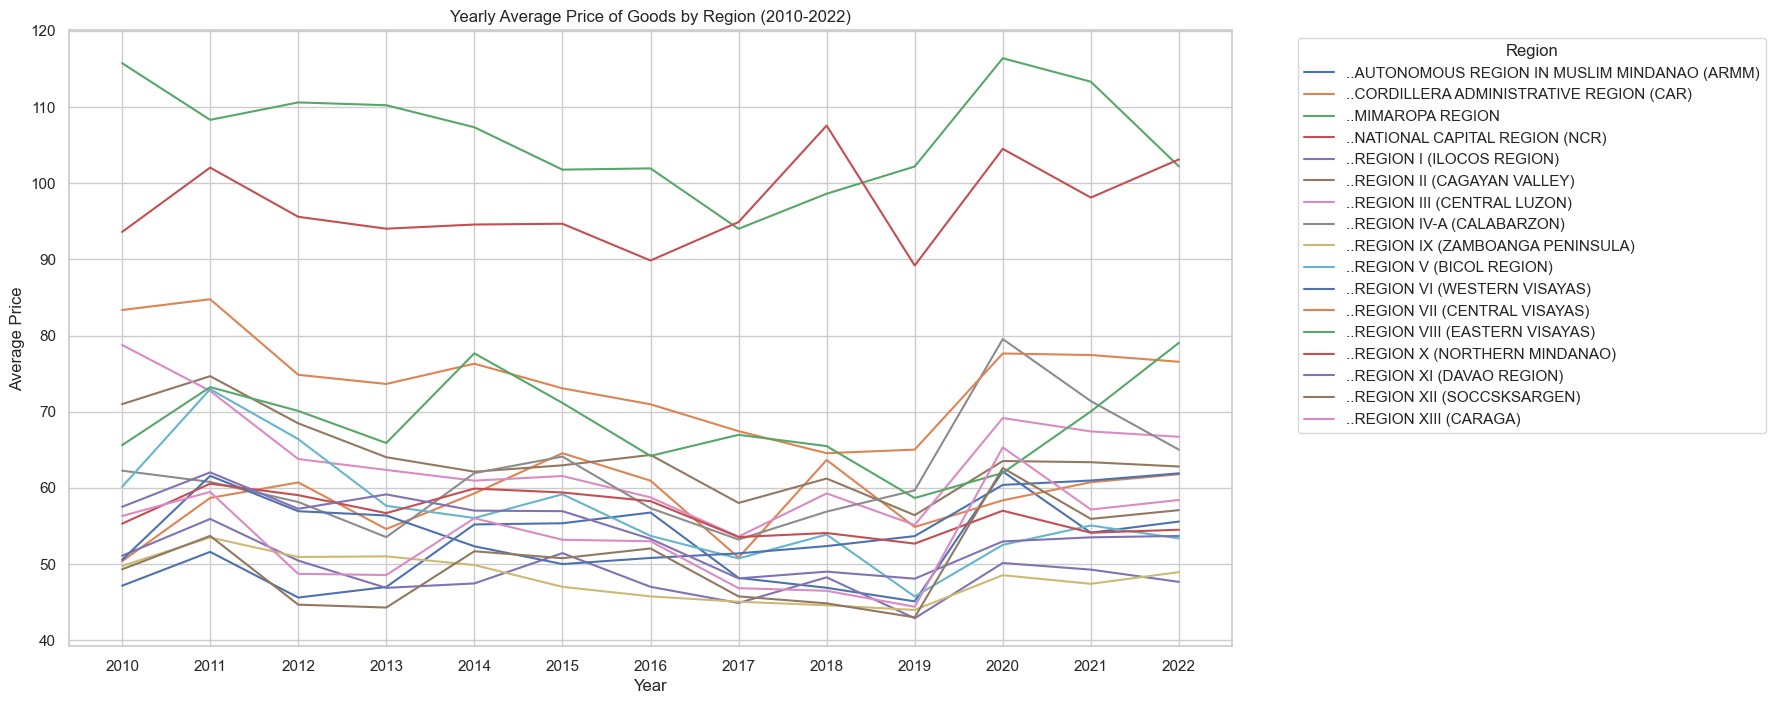

In [ ]:
# Extracting the year columns
year_columns = [str(year) for year in range(2010, 2023)]

# Function to calculate the average price for each year and region
def calculate_yearly_average(dataset):
    # Group by region and calculate mean for each year
    return dataset.groupby('Geolocation')[year_columns].mean()

# Calculating the yearly averages for each dataset
average_BeanAndLegumes = calculate_yearly_average(cleaned_BeanAndLegumes)
average_Cereals = calculate_yearly_average(cleaned_Cereals)
average_CommercialCrops = calculate_yearly_average(cleaned_CommercialCrops)
average_Condiments = calculate_yearly_average(cleaned_Condiments)
average_FruitVegetables = calculate_yearly_average(cleaned_FruitVegetables)
average_Fruits = calculate_yearly_average(cleaned_Fruits)
average_LeafyVegetables = calculate_yearly_average(cleaned_LeafyVegetables)
average_Poultry = calculate_yearly_average(cleaned_Poultry)
average_Rootcrops = calculate_yearly_average(cleaned_Rootcrops)
average_Seafood = calculate_yearly_average(cleaned_Seafood)

# Combining the averages for a single dataset with all goods
combined_averages = pd.concat([average_BeanAndLegumes, average_Cereals, average_CommercialCrops, average_Condiments, average_FruitVegetables, average_Fruits, average_LeafyVegetables, average_Poultry, average_Rootcrops, average_Seafood])

# Calculating the overall average for each region and year
overall_average = combined_averages.groupby(combined_averages.index).mean()

# Plotting the line graph
plt.figure(figsize=(15, 8))
for region in overall_average.index:
    plt.plot(overall_average.columns, overall_average.loc[region, :], label=region)

plt.title('Yearly Average Price of Goods by Region (2010-2022)')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## 4.2 Plotting Wholesale Prices vs GRDP with correlation coefficient

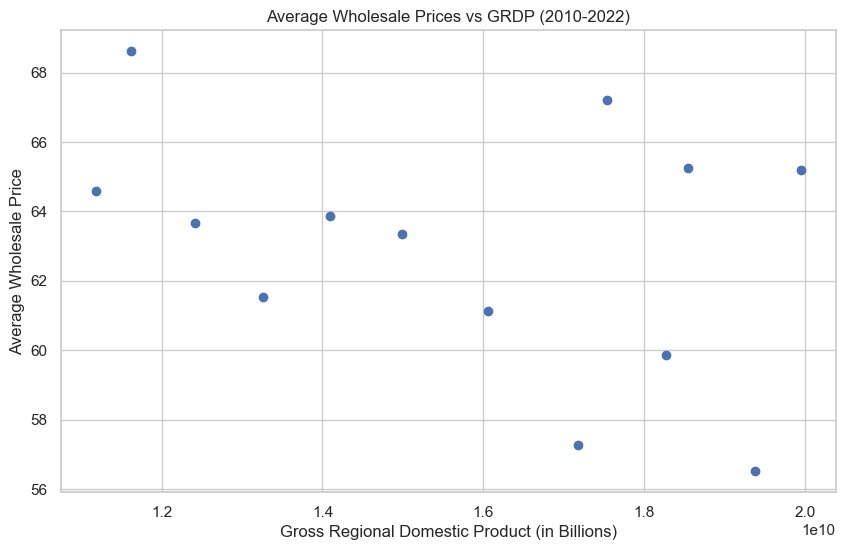

-0.3701122723633014       Average Wholesale Price         GRDP
2010                64.579088  11183860996
2011                68.618904  11615360394
2012                63.663600  12416466192
2013                61.523310  13254643629
2014                63.864255  14096046745
2015                63.360579  14990907451
2016                61.115571  16062675897
2017                57.266902  17175978085
2018                59.861450  18265190258
2019                56.512400  19382750611
2020                67.221235  17537843279
2021                65.257592  18540084220
2022                65.199779  19943630240


In [ ]:
# We will use the columns 'At Constant 2018 Prices' from 2010 to 2022
grdp_YearColumns = ['At Constant 2018 Prices ' + str(year) for year in range(2010, 2023)]

# Summing up GRDP across all regions for each year to get a single GRDP value for each year
aggregated_grdp = GRDP_census[grdp_YearColumns].sum()

# Preparing a dataframe for the average wholesale prices (already calculated as 'overall_average')
# We need to get a single average price per year across all regions
aggregated_wholesale_prices = overall_average.mean()

# Creating a combined DataFrame with GRDP and Wholesale Prices
combined_data = pd.DataFrame({
    'Average Wholesale Price': aggregated_wholesale_prices.values,
    'GRDP': aggregated_grdp.values
}, index=aggregated_wholesale_prices.index)

# Plotting the scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(combined_data['GRDP'], combined_data['Average Wholesale Price'])
plt.title('Average Wholesale Prices vs GRDP (2010-2022)')
plt.xlabel('Gross Regional Domestic Product (in Billions)')
plt.ylabel('Average Wholesale Price')
plt.grid(True)
plt.show()

# Calculating correlation coefficient
PriceGRDP_corrcoef = combined_data['Average Wholesale Price'].corr(combined_data['GRDP'])

# Displaying the correlation coefficient and the combined data for reference
print(PriceGRDP_corrcoef,combined_data)


## 4.3 Plotting Wholesale Prices vs GRDP per Capita with correlation coefficient

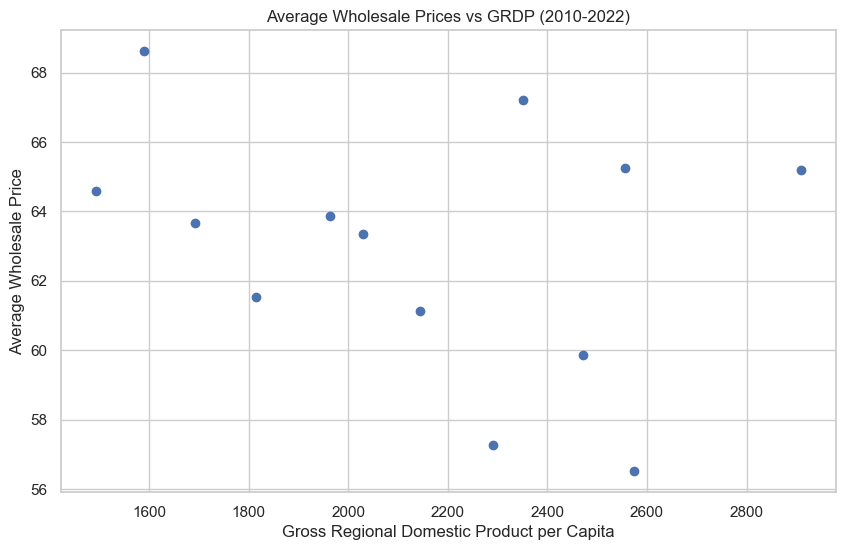

-0.2899042898581588       Average Wholesale Price  GRDP per Capita
2010                64.579088      1493.526969
2011                68.618904      1589.614466
2012                63.663600      1693.295100
2013                61.523310      1814.427039
2014                63.864255      1962.482670
2015                63.360579      2030.203455
2016                61.115571      2143.667727
2017                57.266902      2290.197248
2018                59.861450      2472.044989
2019                56.512400      2574.843840
2020                67.221235      2351.215860
2021                65.257592      2555.771078
2022                65.199779      2908.315860


In [ ]:
# We will use the columns 'GRDP per Capita Prices' for each year from 2010 to 2022
grdpPerCapita_YearColumns = ['GRDP per Capita ' + str(year) for year in range(2010, 2023)]

# Summing up GRDP across all regions for each year to get a single GRDP value for each year
aggregated_grdpPerCapita = GRDP_census[grdpPerCapita_YearColumns].sum()


# Creating a combined DataFrame with GRDP per Capita and Wholesale Prices
combined_dataPerCapita = pd.DataFrame({
    'Average Wholesale Price': aggregated_wholesale_prices.values,
    'GRDP per Capita': aggregated_grdpPerCapita.values
}, index=aggregated_wholesale_prices.index)

# Plotting the scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(combined_dataPerCapita['GRDP per Capita'], combined_data['Average Wholesale Price'])
plt.title('Average Wholesale Prices vs GRDP (2010-2022)')
plt.xlabel('Gross Regional Domestic Product per Capita')
plt.ylabel('Average Wholesale Price')
plt.grid(True)
plt.show()

# Calculating correlation coefficient
PriceGRDPCapita_corrcoef = combined_data['Average Wholesale Price'].corr(combined_dataPerCapita['GRDP per Capita'])

# Displaying the correlation coefficient and the combined data for reference
print(PriceGRDPCapita_corrcoef,combined_dataPerCapita)


## 4.4 Plotting of changes in Average Price of Goods

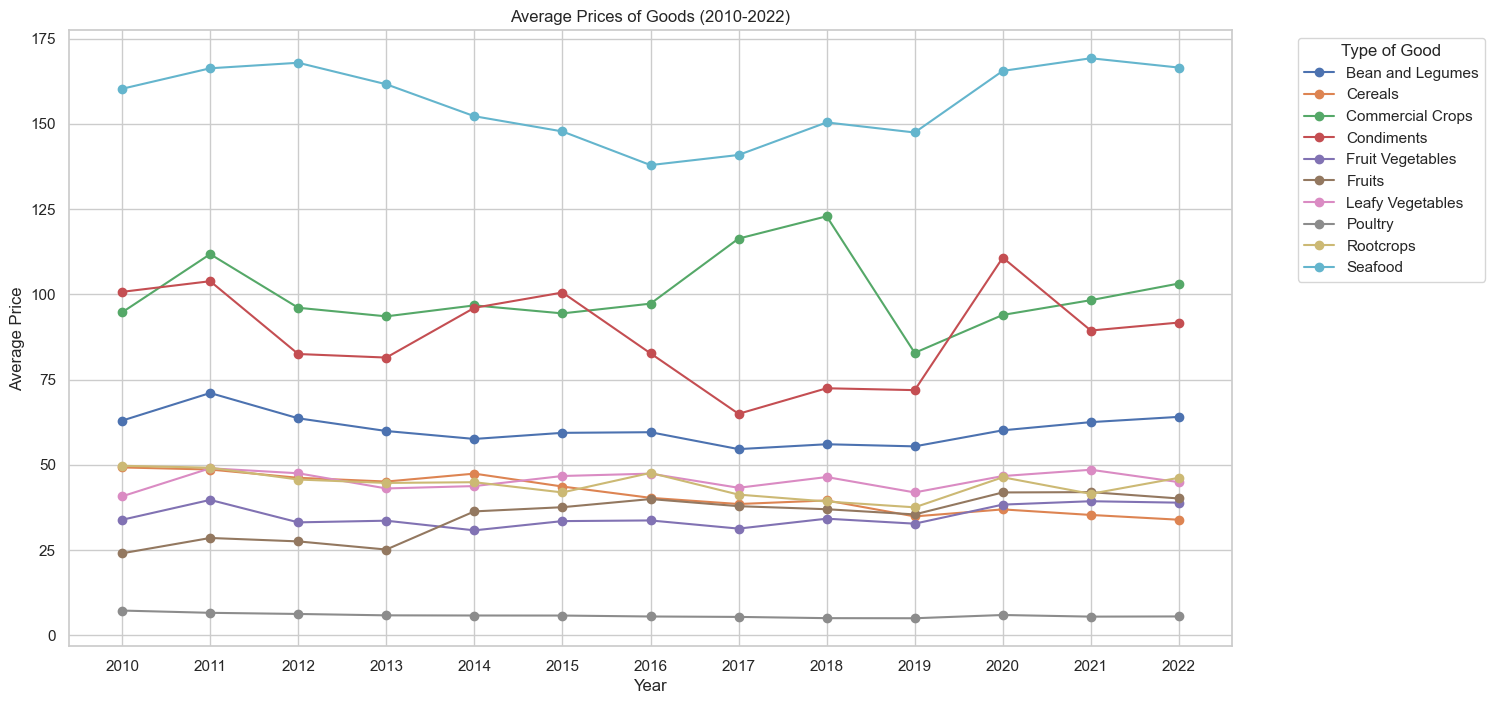

In [ ]:
# Plotting the line graph
plt.figure(figsize=(15, 8))
plt.plot(average_BeanAndLegumes.columns, average_BeanAndLegumes.mean(), label='Bean and Legumes', marker='o')
plt.plot(average_Cereals.columns, average_Cereals.mean(), label='Cereals', marker='o')
plt.plot(average_CommercialCrops.columns, average_CommercialCrops.mean(), label='Commercial Crops', marker='o')
plt.plot(average_Condiments.columns, average_Condiments.mean(), label='Condiments', marker='o')
plt.plot(average_FruitVegetables.columns, average_FruitVegetables.mean(), label='Fruit Vegetables', marker='o')
plt.plot(average_Fruits.columns, average_Fruits.mean(), label='Fruits', marker='o')
plt.plot(average_LeafyVegetables.columns, average_LeafyVegetables.mean(), label='Leafy Vegetables', marker='o')
plt.plot(average_Poultry.columns, average_Poultry.mean(), label='Poultry', marker='o')
plt.plot(average_Rootcrops.columns, average_Rootcrops.mean(), label='Rootcrops', marker='o')
plt.plot(average_Seafood.columns, average_Seafood.mean(), label='Seafood', marker='o')
plt.title('Average Prices of Goods (2010-2022)')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.legend(title='Type of Good', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()

# 5. Regression Analysis of Goods

## 5.1 Tuning Regressions

In this section, we will get an idea of how to tune the regression models that we will use to assess the variables. In particular, we will check linear regression, Ridge, and Lasso models

We will check three different goods in three different regions (one for Luzon, Visayas, and Mindanao)

In [ ]:
YEARS = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

### 5.1.1 Beans and Legumes - National Capital Region (NCR)

In [ ]:
# Select only the NCR data from the beans and legumes
BeansAndLegumes_groups = cleaned_BeanAndLegumes.groupby('Geolocation')
BeansAndLegumes_pivot = pd.pivot_table(BeansAndLegumes_groups.get_group('..NATIONAL CAPITAL REGION (NCR)'), values=YEARS, index = 'Commodity').transpose()
BeansAndLegumes_pivot.reset_index(drop=True, inplace=True)
BeansAndLegumes_pivot

Commodity  Habitchuelas [Snap beans]  Kidney Beans, white  \
0                          47.057362            63.141633   
1                          56.095933            66.532385   
2                          49.688872            69.635812   
3                          47.495072            77.881200   
4                          42.049715           107.220422   
5                          51.116103            90.197155   
6                          44.298658            66.492575   
7                          40.570420            69.580963   
8                          44.541103            70.055644   
9                          48.511786            70.530326   
10                         63.824648            75.183711   
11                         51.125846            82.149486   
12                         55.382612            71.733845   

Commodity  Mongo [Mungbean], Yellow  Mongo [Mungbean], green  \
0                        125.289644               101.908454   
1                        138.995952               100.162640   
2                        123.279804                71.749017   
3                         83.293897                71.999582   
4                        100.944724                80.910766   
5                         90.041787                83.659743   
6                         97.994339                75.488302   
7                        100.523430                74.257699   
8                         87.264446                66.387257   
9                         74.005462                58.516816   
10                        80.022215                82.856790   
11                        76.589302                75.176876   
12                        71.743125                75.046780   

Commodity  Peanut without shell, dry  Stringbeans  Sweet Peas  
0                          90.047080    45.256420  163.155993  
1                          99.571039    50.316444  198.960046  
2                          98.478203    44.634314  167.257311  
3                          86.509360    47.280708  160.773164  
4                          72.742196    42.265680  144.823792  
5                         103.893450    48.725825  141.289355  
6                          88.931729    46.840201  143.307384  
7                          74.004331    39.039660  152.643171  
8                          72.136544    41.486990  159.155016  
9                          70.268756    43.934321  165.666860  
10                         71.632706    60.543602  183.364776  
11                         72.172984    51.901685  215.285565  
12                         77.589480    46.297562  191.463480

In [ ]:
# Append to the data frame columns for GRDP and GRDP per capita

BeansAndLegumes_pivot = pd.concat([BeansAndLegumes_pivot, GRDPs['..NATIONAL CAPITAL REGION (NCR)']], axis=1)
BeansAndLegumes_pivot.columns = list(BeansAndLegumes_pivot.columns[:-1]) + ['GRDP']

BeansAndLegumes_pivot = pd.concat([BeansAndLegumes_pivot, GRDP_percapita['..NATIONAL CAPITAL REGION (NCR)']], axis=1)
BeansAndLegumes_pivot.columns = list(BeansAndLegumes_pivot.columns[:-1]) + ['GRDP per capita']

BeansAndLegumes_pivot.index = range(2010,2023)
BeansAndLegumes_pivot.index.name='Year'

BeansAndLegumes_pivot

Habitchuelas [Snap beans]  Kidney Beans, white  \
Year                                                   
2010                  47.057362            63.141633   
2011                  56.095933            66.532385   
2012                  49.688872            69.635812   
2013                  47.495072            77.881200   
2014                  42.049715           107.220422   
2015                  51.116103            90.197155   
2016                  44.298658            66.492575   
2017                  40.570420            69.580963   
2018                  44.541103            70.055644   
2019                  48.511786            70.530326   
2020                  63.824648            75.183711   
2021                  51.125846            82.149486   
2022                  55.382612            71.733845   

      Mongo [Mungbean], Yellow  Mongo [Mungbean], green  \
Year                                                      
2010                125.289644               101.908454   
2011                138.995952               100.162640   
2012                123.279804                71.749017   
2013                 83.293897                71.999582   
2014                100.944724                80.910766   
2015                 90.041787                83.659743   
2016                 97.994339                75.488302   
2017                100.523430                74.257699   
2018                 87.264446                66.387257   
2019                 74.005462                58.516816   
2020                 80.022215                82.856790   
2021                 76.589302                75.176876   
2022                 71.743125                75.046780   

      Peanut without shell, dry  Stringbeans  Sweet Peas        GRDP  \
Year                                                                   
2010                  90.047080    45.256420  163.155993  3745124533   
2011                  99.571039    50.316444  198.960046  3833040760   
2012                  98.478203    44.634314  167.257311  4072189800   
2013                  86.509360    47.280708  160.773164  4339858704   
2014                  72.742196    42.265680  144.823792  4576914911   
2015                 103.893450    48.725825  141.289355  4865073608   
2016                  88.931729    46.840201  143.307384  5216091453   
2017                  74.004331    39.039660  152.643171  5507681038   
2018                  72.136544    41.486990  159.155016  5814440130   
2019                  70.268756    43.934321  165.666860  6224134457   
2020                  71.632706    60.543602  183.364776  5599931197   
2021                  72.172984    51.901685  215.285565  5845619151   
2022                  77.589480    46.297562  191.463480  6265608932   

      GRDP per capita  
Year                   
2010       257.520815  
2011       268.414338  
2012       289.705461  
2013       312.036496  
2014       332.612811  
2015       351.972871  
2016       379.132130  
2017       406.026589  
2018       439.104775  
2019       471.015885  
2020       430.185437  
2021       456.637025  
2022       510.881557

In [ ]:
# Separate features and target variable
features = BeansAndLegumes_pivot.iloc[:, :-2]
target = BeansAndLegumes_pivot['GRDP per capita']

# Split the data into training and testing sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

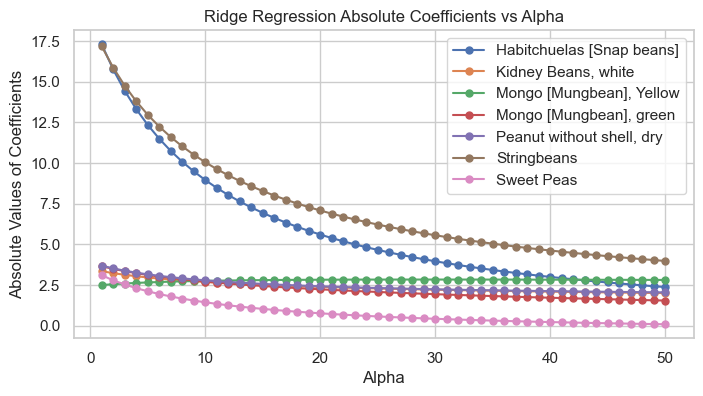

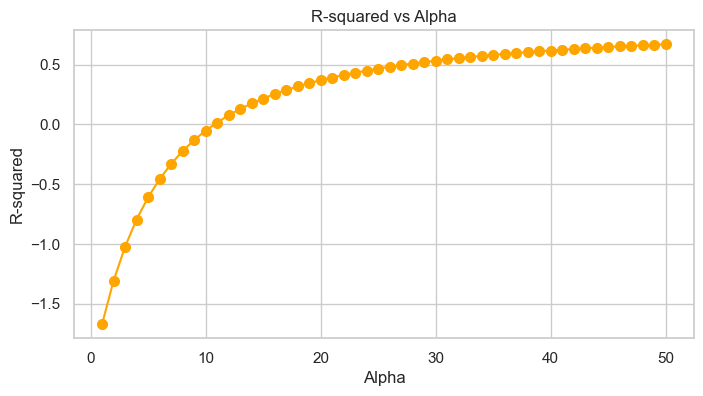

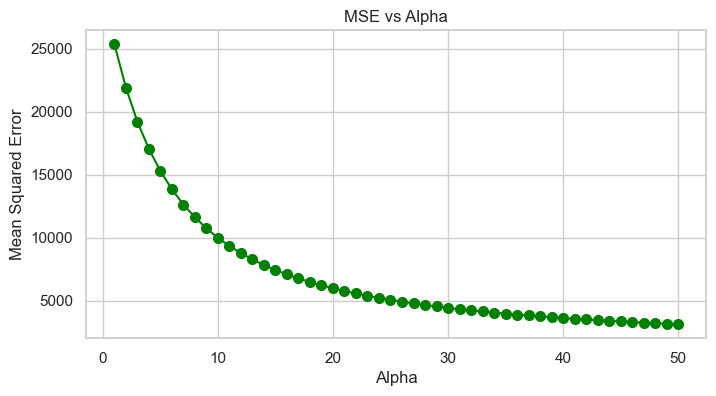

In [ ]:
# Initialize alpha values from 1 to 50
alphas = np.arange(1, 51)
coefficients = []
r2_values = []
mse_values = []

# Fit Ridge Regression for each alpha value
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(features_train, target_train)

    # Coefficients
    coefficients.append(ridge_model.coef_)

    # R-squared
    predictions = ridge_model.predict(features_test)
    r2_values.append(r2_score(target_test, predictions))

    # Mean Squared Error
    mse_values.append(mean_squared_error(target_test, predictions))

# Convert the lists into numpy arrays for easy plotting
coefficients = np.array(coefficients)
r2_values = np.array(r2_values)
mse_values = np.array(mse_values)

# Plot Absolute Values of Coefficients vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, np.abs(coefficients), marker='o', markersize=5)
plt.xlabel('Alpha')
plt.ylabel('Absolute Values of Coefficients')
plt.title('Ridge Regression Absolute Coefficients vs Alpha')
plt.legend(features.columns)
plt.show()

# Plot R-squared vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, r2_values, marker='o', markersize=7, color='orange')
plt.xlabel('Alpha')
plt.ylabel('R-squared')
plt.title('R-squared vs Alpha')
plt.show()

# Plot MSE vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, mse_values, marker='o', markersize=7, color='green')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha')
plt.show()

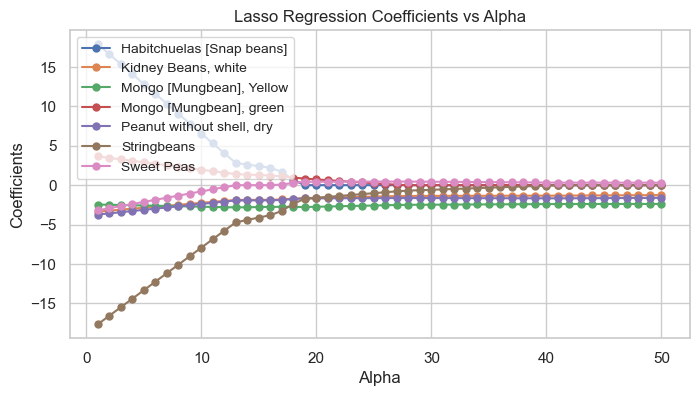

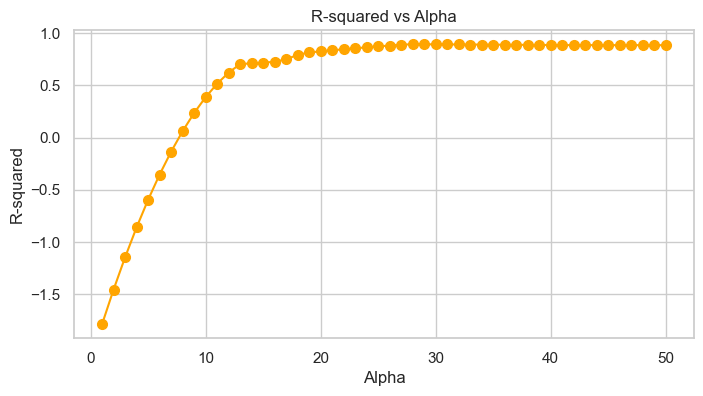

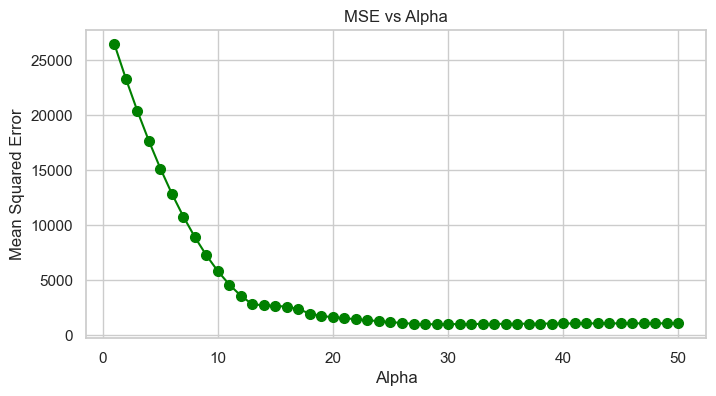

In [ ]:
# Initialize alpha values from 1 to 50
alphas = np.arange(1, 51)
coefficients = []
r2_values = []
mse_values = []

# Fit Lasso Regression for each alpha value
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(features_train, target_train)

    # Coefficients
    coefficients.append(lasso_model.coef_)

    # R-squared
    predictions = lasso_model.predict(features_test)
    r2_values.append(r2_score(target_test, predictions))

    # Mean Squared Error
    mse_values.append(mean_squared_error(target_test, predictions))

# Convert the lists into numpy arrays for easy plotting
coefficients = np.array(coefficients)
r2_values = np.array(r2_values)
mse_values = np.array(mse_values)

# Plot Coefficients vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, coefficients, marker='o', markersize=5)
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Regression Coefficients vs Alpha')

# Make the legend smaller and relocate it to the top-left corner
plt.legend(features.columns, loc='upper left', fontsize='small')

plt.show()

# Plot R-squared vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, r2_values, marker='o', markersize=7, color='orange')
plt.xlabel('Alpha')
plt.ylabel('R-squared')
plt.title('R-squared vs Alpha')
plt.show()

# Plot MSE vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, mse_values, marker='o', markersize=7, color='green')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha')
plt.show()

In [ ]:
# alpha ~= 20 seems to be suitable

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)
linear_predictions = linear_model.predict(features_test)

# Ridge Regression
ridge_model = Ridge(alpha=20)  # You can adjust the alpha parameter
ridge_model.fit(features_train, target_train)
ridge_predictions = ridge_model.predict(features_test)

# Lasso Regression
lasso_model = Lasso(alpha=20)  # You can adjust the alpha parameter
lasso_model.fit(features_train, target_train)
lasso_predictions = lasso_model.predict(features_test)

# Evaluate the models
linear_mse = mean_squared_error(target_test, linear_predictions)
ridge_mse = mean_squared_error(target_test, ridge_predictions)
lasso_mse = mean_squared_error(target_test, lasso_predictions)

linear_r2 = r2_score(target_test, linear_predictions)
ridge_r2 = r2_score(target_test, ridge_predictions)
lasso_r2 = r2_score(target_test, lasso_predictions)

# List Coeffcients
linear_coeffs = linear_model.coef_
ridge_coeffs = ridge_model.coef_
lasso_coeffs = lasso_model.coef_


# Display Results
print("Linear Regression:")
print(f'Mean Squared Error: {linear_mse}')
print(f'R-squared: {linear_r2}')
print(f'Coefficients: {linear_coeffs}\n')

print("Ridge Regression:")
print(f'Mean Squared Error: {ridge_mse}')
print(f'R-squared: {ridge_r2}')
print(f'Coefficients: {ridge_coeffs}\n')

print("Lasso Regression:")
print(f'Mean Squared Error: {lasso_mse}')
print(f'R-squared: {lasso_r2}')
print(f'Coefficients: {lasso_coeffs}\n')

Linear Regression:
Mean Squared Error: 29853.523927544436
R-squared: -2.1448979090894347
Coefficients: [ 19.16389561  -3.483757    -2.42733871   3.84456614  -3.88116279
 -18.74933473  -3.46259097]

Ridge Regression:
Mean Squared Error: 5989.661913224233
R-squared: 0.3690233932593928
Coefficients: [ 5.59561074 -2.37758305 -2.81745038  2.2278953  -2.41365251 -7.07654459
 -0.75281916]

Lasso Regression:
Mean Squared Error: 1653.4509919405054
R-squared: 0.8258183998660937
Coefficients: [ 0.         -1.60933361 -2.74091577  0.73032121 -1.67379256 -1.60401107
  0.43106924]



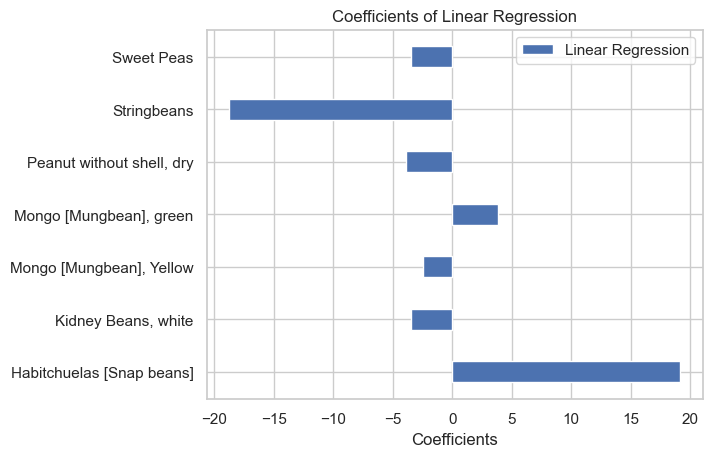

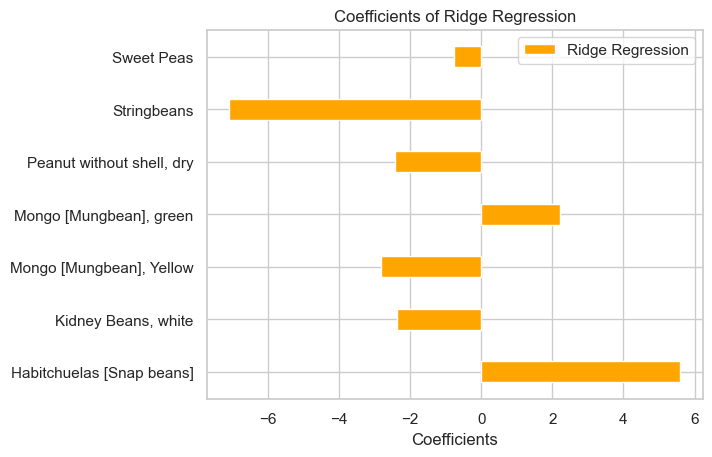

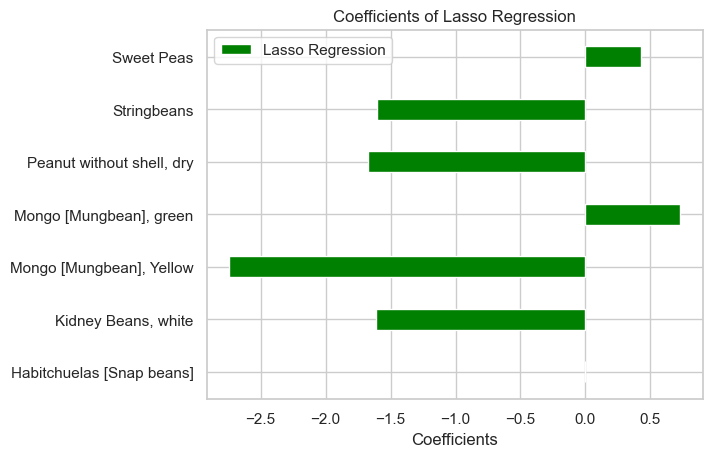

In [ ]:
# Plot Coefficients - Linear Regression
labels = features.columns
y = np.arange(len(labels))

fig, ax = plt.subplots()
ax.barh(y, linear_coeffs, 0.4, label='Linear Regression')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Coefficients')
ax.set_title('Coefficients of Linear Regression')
ax.legend()
plt.show()

# Plot Coefficients - Ridge Regression
fig, ax = plt.subplots()
ax.barh(y, ridge_coeffs, 0.4, label='Ridge Regression', color='orange')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Coefficients')
ax.set_title('Coefficients of Ridge Regression')
ax.legend()
plt.show()

# Plot Coefficients - Lasso Regression
fig, ax = plt.subplots()
ax.barh(y, lasso_coeffs, 0.4, label='Lasso Regression', color='green')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Coefficients')
ax.set_title('Coefficients of Lasso Regression')
ax.legend()
plt.show()

### 5.1.2 Seafood - REGION VII (CENTRAL VISAYAS)

In [ ]:
# Select only the Region VII data from the seafood
Seafood_groups = cleaned_Seafood.groupby('Geolocation')
Seafood_pivot = pd.pivot_table(Seafood_groups.get_group('..REGION VII (CENTRAL VISAYAS)'), values=YEARS, index = 'Commodity').transpose()
Seafood_pivot.reset_index(drop=True, inplace=True)
Seafood_pivot

Commodity  Alumahan [Indian mackerel]  Bangus [Milkfish]  \
0                          152.005920         155.231416   
1                          169.759590         165.407205   
2                          163.611324         160.915515   
3                          145.389146         152.476850   
4                          150.768175         144.417565   
5                          142.345678         132.415730   
6                           99.451927         132.403765   
7                           96.873488         130.531832   
8                          122.990000         146.610000   
9                          124.788502         139.092286   
10                         163.982041         157.405694   
11                         178.537317         165.868583   
12                         183.757472         170.840967   

Commodity  Bisugo [Threadfin bream]  Crab, Alimasag [Blue crab]  \
0                        219.174212                  314.025056   
1                        226.373702                  331.244683   
2                        208.152738                  337.142615   
3                        188.687294                  298.441433   
4                        188.819564                  282.981071   
5                        184.184515                  268.490511   
6                        178.797842                  274.533655   
7                        125.648534                  226.227331   
8                        141.990000                  241.810000   
9                        169.460752                  256.394608   
10                       243.813897                  299.650411   
11                       219.189833                  296.574765   
12                       226.818606                  276.723286   

Commodity  Dalagang-Bukid, lapad [Caesio]  Dilis [Anchovies]  \
0                              217.561464          86.751659   
1                              226.754329         104.010433   
2                              210.893981          81.252870   
3                              194.890789          76.603336   
4                              191.602856          70.849804   
5                              181.523388          71.111239   
6                              120.681948          56.200489   
7                              123.153340          73.099539   
8                              152.280000          75.520000   
9                              145.363727         101.482470   
10                             214.917512          98.353845   
11                             188.431371         102.919886   
12                             200.930553         100.644163   

Commodity  Galunggong [Roundscad]  Hasa-hasa [Indo-Pacific mackerel]  \
0                      112.591071                         130.065460   
1                      139.011558                         153.045105   
2                      120.342088                         147.633359   
3                      106.427830                         134.778644   
4                      104.719722                         138.171493   
5                      109.907028                         132.230930   
6                       92.799624                         106.689173   
7                      103.534478                          90.501642   
8                      114.050000                         112.320000   
9                      113.931187                         119.986047   
10                     147.405901                         149.185260   
11                     162.244713                         156.507742   
12                     160.924246                         151.860676   

Commodity  Lapu-lapu [Grouper]  Matang-baka [Big-eyed scad]  Pusit [Squid]  \
0                   454.493626                   156.808719     247.654277   
1                   517.851150                   168.319828     228.343032   
2                   496.316457                   139.939705     220.768515   
3 

In [ ]:
# Append to the data frame columns for GRDP and GRDP per capita
Seafood_pivot = pd.concat([Seafood_pivot, GRDPs['..REGION VII (CENTRAL VISAYAS)']], axis=1)
Seafood_pivot.columns = list(Seafood_pivot.columns[:-1]) + ['GRDP']

Seafood_pivot = pd.concat([Seafood_pivot, GRDP_percapita['..REGION VII (CENTRAL VISAYAS)']], axis=1)
Seafood_pivot.columns = list(Seafood_pivot.columns[:-1]) + ['GRDP per capita']

Seafood_pivot.index = range(2010,2023)
Seafood_pivot.index.name='Year'

Seafood_pivot

Alumahan [Indian mackerel]  Bangus [Milkfish]  Bisugo [Threadfin bream]  \
Year                                                                            
2010                  152.005920         155.231416                219.174212   
2011                  169.759590         165.407205                226.373702   
2012                  163.611324         160.915515                208.152738   
2013                  145.389146         152.476850                188.687294   
2014                  150.768175         144.417565                188.819564   
2015                  142.345678         132.415730                184.184515   
2016                   99.451927         132.403765                178.797842   
2017                   96.873488         130.531832                125.648534   
2018                  122.990000         146.610000                141.990000   
2019                  124.788502         139.092286                169.460752   
2020                  163.982041         157.405694                243.813897   
2021                  178.537317         165.868583                219.189833   
2022                  183.757472         170.840967                226.818606   

      Crab, Alimasag [Blue crab]  Dalagang-Bukid, lapad [Caesio]  \
Year                                                               
2010                  314.025056                      217.561464   
2011                  331.244683                      226.754329   
2012                  337.142615                      210.893981   
2013                  298.441433                      194.890789   
2014                  282.981071                      191.602856   
2015                  268.490511                      181.523388   
2016                  274.533655                      120.681948   
2017                  226.227331                      123.153340   
2018                  241.810000                      152.280000   
2019                  256.394608                      145.363727   
2020                  299.650411                      214.917512   
2021                  296.574765                      188.431371   
2022                  276.723286                      200.930553   

      Dilis [Anchovies]  Galunggong [Roundscad]  \
Year                                              
2010          86.751659              112.591071   
2011         104.010433              139.011558   
2012          81.252870              120.342088   
2013          76.603336              106.427830   
2014          70.849804              104.719722   
2015          71.111239              109.907028   
2016          56.200489               92.799624   
2017          73.099539              103.534478   
2018          75.520000              114.050000   
2019         101.482470              113.931187   
2020          98.353845              147.405901   
2021         102.919886              162.244713   
2022         100.644163              160.924246   

      Hasa-hasa [Indo-Pacific mackerel]  Lapu-lapu [Grouper]  \
Year                                                           
2010                         130.065460           454.493626   
2011                         153.045105           517.851150   
2012                         147.633359           496.316457   
2013                         134.778644           431.072713   
2014                         138.171493           406.216871   
2015                         132.230930           402.236805   
2016                         106.689173           329.449561   
2017                          90.501642           313.698330   
2018                         112.320000           488.530000   
2019                         119.986047           463.559342   
2020                         149.185260           424.736274   
2021                         156.507742           385.828612   
2022                         151.860676           371.046801   

      Matang-baka [Big-eyed scad]  Pusit [

In [ ]:
# Separate features and target variable
features = Seafood_pivot.iloc[:, :-2]
target = Seafood_pivot['GRDP per capita']

# Split the data into training and testing sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

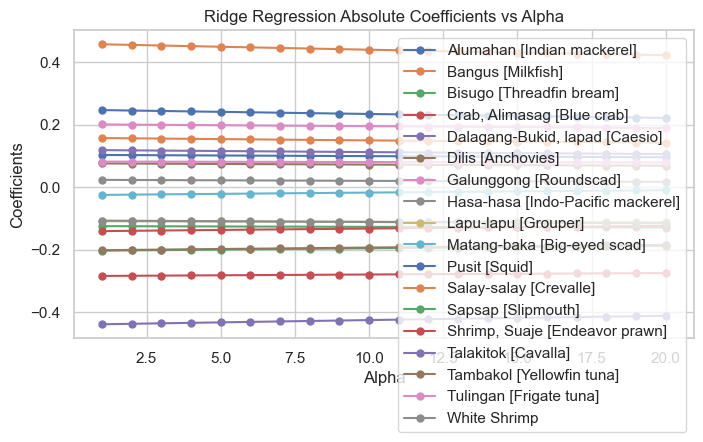

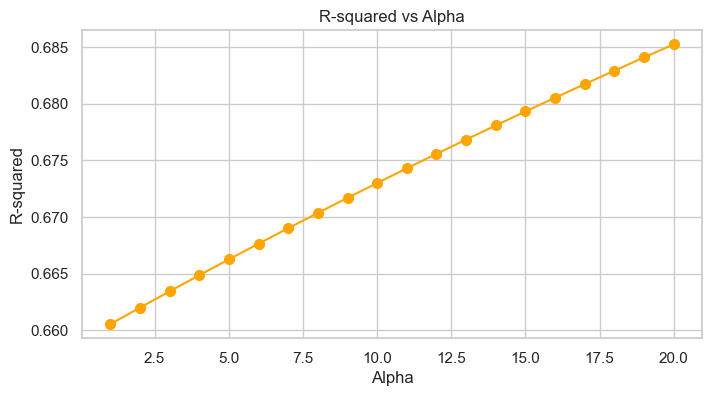

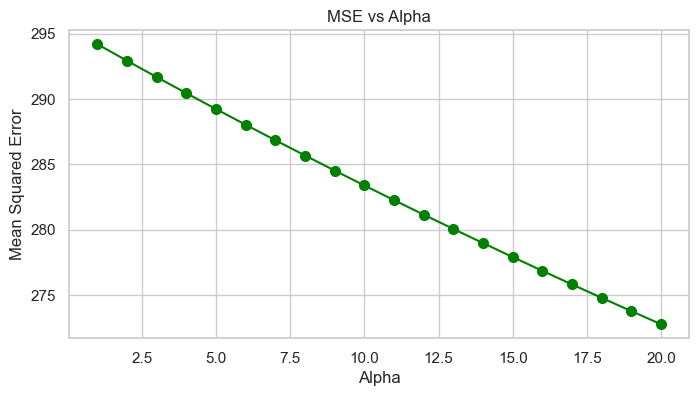

In [ ]:
# Initialize alpha values from 1 to 20
alphas = np.arange(1, 21)
coefficients = []
r2_values = []
mse_values = []

# Fit Ridge Regression for each alpha value
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(features_train, target_train)

    # Coefficients
    coefficients.append(ridge_model.coef_)

    # R-squared
    predictions = ridge_model.predict(features_test)
    r2_values.append(r2_score(target_test, predictions))

    # Mean Squared Error
    mse_values.append(mean_squared_error(target_test, predictions))

# Convert the lists into numpy arrays for easy plotting
coefficients = np.array(coefficients)
r2_values = np.array(r2_values)
mse_values = np.array(mse_values)

# Plot Absolute Values of Coefficients vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, coefficients, marker='o', markersize=5)
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Regression Absolute Coefficients vs Alpha')
plt.legend(features.columns)
plt.show()

# Plot R-squared vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, r2_values, marker='o', markersize=7, color='orange')
plt.xlabel('Alpha')
plt.ylabel('R-squared')
plt.title('R-squared vs Alpha')
plt.show()

# Plot MSE vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, mse_values, marker='o', markersize=7, color='green')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha')
plt.show()

H:\ANACONDA\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.466e-01, tolerance: 3.879e-01
  model = cd_fast.enet_coordinate_descent(
H:\ANACONDA\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.424e-01, tolerance: 3.879e-01
  model = cd_fast.enet_coordinate_descent(


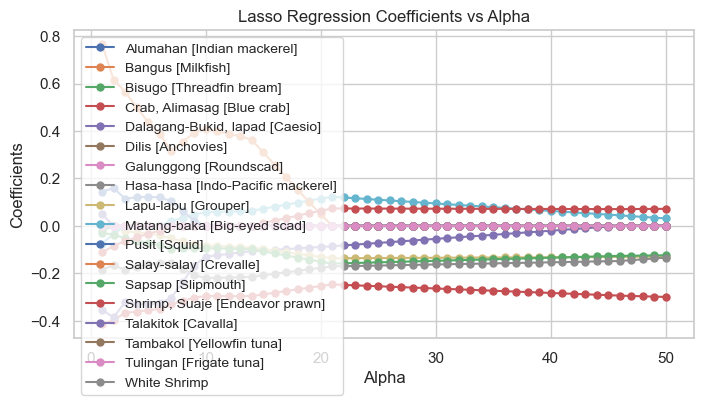

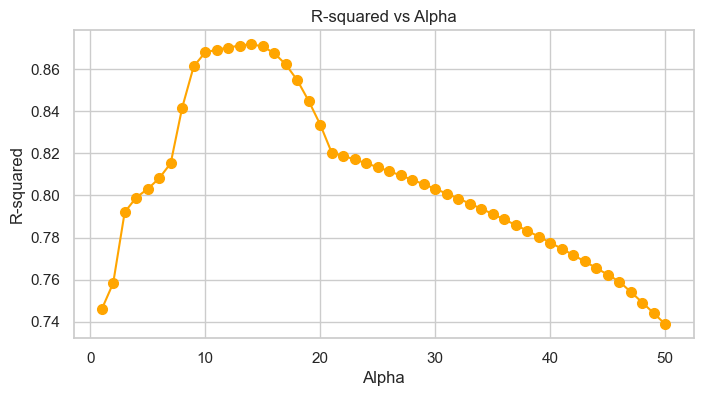

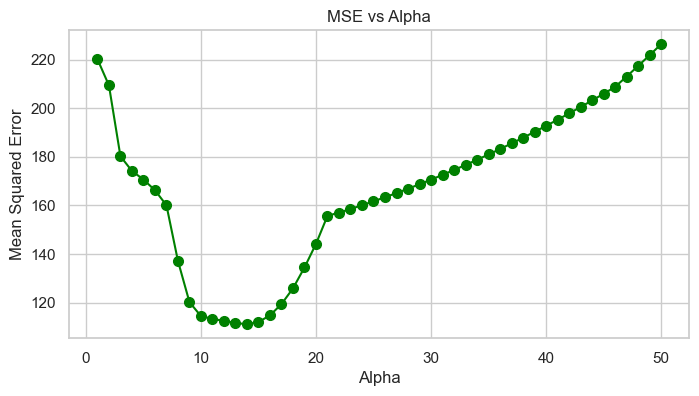

In [ ]:
# Initialize alpha values from 1 to 50
alphas = np.arange(1, 51)
coefficients = []
r2_values = []
mse_values = []

# Fit Lasso Regression for each alpha value
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(features_train, target_train)

    # Coefficients
    coefficients.append(lasso_model.coef_)

    # R-squared
    predictions = lasso_model.predict(features_test)
    r2_values.append(r2_score(target_test, predictions))

    # Mean Squared Error
    mse_values.append(mean_squared_error(target_test, predictions))

# Convert the lists into numpy arrays for easy plotting
coefficients = np.array(coefficients)
r2_values = np.array(r2_values)
mse_values = np.array(mse_values)

# Plot Coefficients vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, coefficients, marker='o', markersize=5)
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Regression Coefficients vs Alpha')

# Make the legend smaller and relocate it to the top-left corner
plt.legend(features.columns, loc='upper left', fontsize='small')

plt.show()

# Plot R-squared vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, r2_values, marker='o', markersize=7, color='orange')
plt.xlabel('Alpha')
plt.ylabel('R-squared')
plt.title('R-squared vs Alpha')
plt.show()

# Plot MSE vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, mse_values, marker='o', markersize=7, color='green')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha')
plt.show()

In [ ]:
# alpha ~= 15 seems to be suitable based on these graphs

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)
linear_predictions = linear_model.predict(features_test)

# Ridge Regression
ridge_model = Ridge(alpha=15)  # You can adjust the alpha parameter
ridge_model.fit(features_train, target_train)
ridge_predictions = ridge_model.predict(features_test)

# Lasso Regression
lasso_model = Lasso(alpha=15)  # You can adjust the alpha parameter
lasso_model.fit(features_train, target_train)
lasso_predictions = lasso_model.predict(features_test)

# Evaluate the models
linear_mse = mean_squared_error(target_test, linear_predictions)
ridge_mse = mean_squared_error(target_test, ridge_predictions)
lasso_mse = mean_squared_error(target_test, lasso_predictions)

linear_r2 = r2_score(target_test, linear_predictions)
ridge_r2 = r2_score(target_test, ridge_predictions)
lasso_r2 = r2_score(target_test, lasso_predictions)

# List Coeffcients
linear_coeffs = linear_model.coef_
ridge_coeffs = ridge_model.coef_
lasso_coeffs = lasso_model.coef_

# Display Results
print("Linear Regression:")
print(f'Mean Squared Error: {linear_mse}')
print(f'R-squared: {linear_r2}')
print(f'Coefficients: {linear_coeffs}\n')

print("Ridge Regression:")
print(f'Mean Squared Error: {ridge_mse}')
print(f'R-squared: {ridge_r2}')
print(f'Coefficients: {ridge_coeffs}\n')

print("Lasso Regression:")
print(f'Mean Squared Error: {lasso_mse}')
print(f'R-squared: {lasso_r2}')
print(f'Coefficients: {lasso_coeffs}\n')

Linear Regression:
Mean Squared Error: 455.14873627328933
R-squared: 0.47481507140901624
Coefficients: [ 0.15625137  0.55374714 -0.24249992 -0.29075838 -0.56646941  0.02097978
  0.1487237   0.25923264 -0.13512275  0.03990305  0.15464306  0.38607102
 -0.12449947 -0.20931362 -0.08140977  0.01707194  0.04942663 -0.05290143]

Ridge Regression:
Mean Squared Error: 277.9048072686645
R-squared: 0.679332480288708
Coefficients: [ 0.22766793  0.14576284 -0.19192093 -0.27730088 -0.41849908 -0.18902607
  0.19210334  0.01852189 -0.1115621  -0.01363789  0.09729562  0.43073471
 -0.12820833 -0.12833771  0.10885751  0.07027875  0.07954011 -0.11367111]

Lasso Regression:
Mean Squared Error: 112.00670670719836
R-squared: 0.8707582168735039
Coefficients: [ 0.          0.          0.         -0.28919982 -0.10392325  0.
  0.         -0.         -0.09808661  0.0721923   0.          0.31053929
 -0.10748467  0.01179879  0.          0.          0.         -0.20836091]



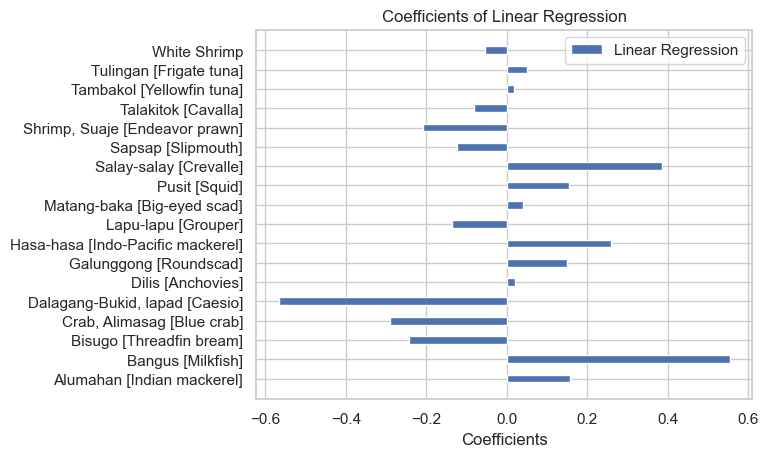

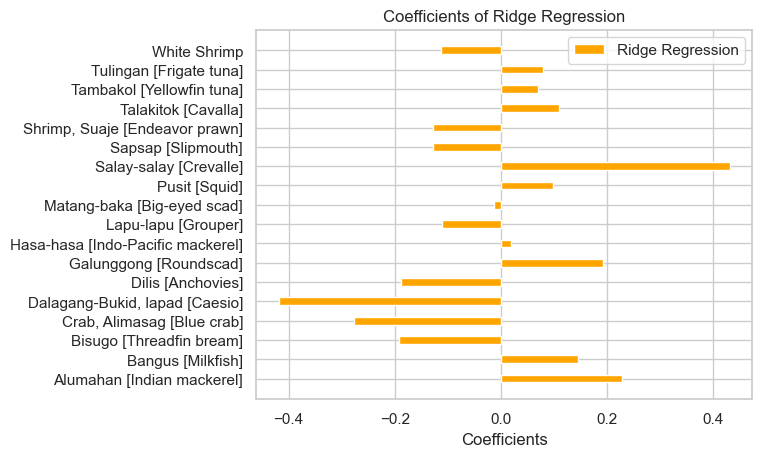

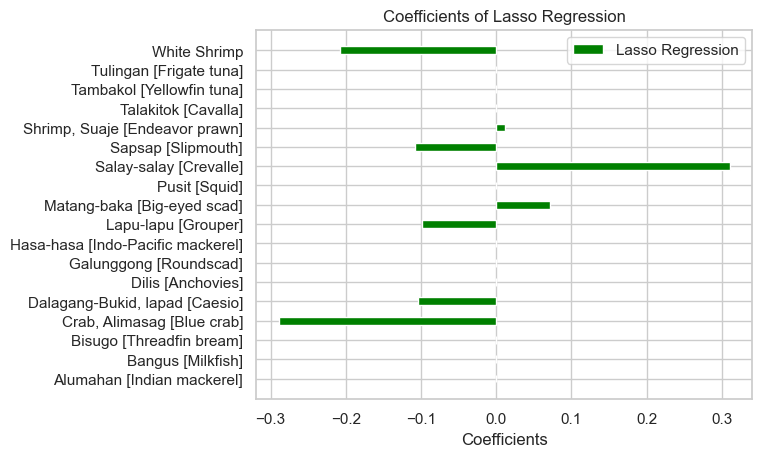

In [ ]:
# Plot Coefficients - Linear Regression
labels = features.columns
y = np.arange(len(labels))

fig, ax = plt.subplots()
ax.barh(y, linear_coeffs, 0.4, label='Linear Regression')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Coefficients')
ax.set_title('Coefficients of Linear Regression')
ax.legend()
plt.show()

# Plot Coefficients - Ridge Regression
fig, ax = plt.subplots()
ax.barh(y, ridge_coeffs, 0.4, label='Ridge Regression', color='orange')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Coefficients')
ax.set_title('Coefficients of Ridge Regression')
ax.legend()
plt.show()

# Plot Coefficients - Lasso Regression
fig, ax = plt.subplots()
ax.barh(y, lasso_coeffs, 0.4, label='Lasso Regression', color='green')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Coefficients')
ax.set_title('Coefficients of Lasso Regression')
ax.legend()
plt.show()

### 5.1.3 Cereals - 'REGION XI (DAVAO REGION)'

In [ ]:
# Select only the Region XI data from the cereals
Cereals_groups = cleaned_Cereals.groupby('Geolocation')
Cereals_pivot = pd.pivot_table(Cereals_groups.get_group('..REGION XI (DAVAO REGION)'), values=YEARS, index = 'Commodity').transpose()
Cereals_pivot.reset_index(drop=True, inplace=True)
Cereals_pivot

Commodity  Corngrits White  Corngrits Yellow  Regular Milled Rice (RMR)  \
0                35.536243         33.053671                  50.591268   
1                43.941569         34.794897                  51.057544   
2                38.128182         33.921813                  49.902827   
3                36.942555         30.160250                  49.171710   
4                35.701435         29.923168                  52.706048   
5                30.294460         27.619171                  47.416308   
6                26.109880         24.652205                  52.732862   
7                26.473818         22.561695                  42.186618   
8                28.960000         23.750000                  42.400000   
9                23.247316         23.891777                  32.110997   
10               25.064371         24.175707                  34.577118   
11               28.842813         24.463012                  32.047570   
12               31.564374         24.753730                  30.065088   

Commodity  Rice Premium  Well Milled Rice (WMR)  
0             62.294822               56.088392  
1             62.695660               56.552373  
2             59.685820               54.507526  
3             60.290489               54.273444  
4             62.776742               57.507513  
5             58.359512               52.728667  
6             54.377119               49.922464  
7             51.843667               47.159837  
8             51.740000               46.330000  
9             39.209414               35.996446  
10            39.868710               37.838920  
11            36.663946               34.708663  
12            33.654554               32.261100

In [ ]:
# Append to the data frame columns for GRDP and GRDP per capita
Cereals_pivot = pd.concat([Cereals_pivot, GRDPs['..REGION XI (DAVAO REGION)']], axis=1)
Cereals_pivot.columns = list(Cereals_pivot.columns[:-1]) + ['GRDP']

Cereals_pivot = pd.concat([Cereals_pivot, GRDP_percapita['..REGION XI (DAVAO REGION)']], axis=1)
Cereals_pivot.columns = list(Cereals_pivot.columns[:-1]) + ['GRDP per capita']

Cereals_pivot.index = range(2010,2023)
Cereals_pivot.index.name='Year'

Cereals_pivot

Corngrits White  Corngrits Yellow  Regular Milled Rice (RMR)  \
Year                                                                 
2010        35.536243         33.053671                  50.591268   
2011        43.941569         34.794897                  51.057544   
2012        38.128182         33.921813                  49.902827   
2013        36.942555         30.160250                  49.171710   
2014        35.701435         29.923168                  52.706048   
2015        30.294460         27.619171                  47.416308   
2016        26.109880         24.652205                  52.732862   
2017        26.473818         22.561695                  42.186618   
2018        28.960000         23.750000                  42.400000   
2019        23.247316         23.891777                  32.110997   
2020        25.064371         24.175707                  34.577118   
2021        28.842813         24.463012                  32.047570   
2022        31.564374         24.753730                  30.065088   

      Rice Premium  Well Milled Rice (WMR)       GRDP  GRDP per capita  
Year                                                                    
2010     62.294822               56.088392  474508281        90.288810  
2011     62.695660               56.552373  493082130        96.092696  
2012     59.685820               54.507526  528097604        97.945271  
2013     60.290489               54.273444  560762183       104.859343  
2014     62.776742               57.507513  611602549       115.518646  
2015     58.359512               52.728667  660489974       123.211254  
2016     54.377119               49.922464  721550629       135.810426  
2017     51.843667               47.159837  785051181       148.714151  
2018     51.740000               46.330000  841429225       164.874654  
2019     39.209414               35.996446  900885668       178.334820  
2020     39.868710               37.838920  833225496       169.848657  
2021     36.663946               34.708663  882189256       184.444331  
2022     33.654554               32.261100  954074121       208.964652

In [ ]:
# Separate features and target variable
features = Cereals_pivot.iloc[:, :-2]
target = Cereals_pivot['GRDP per capita']

# Split the data into training and testing sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

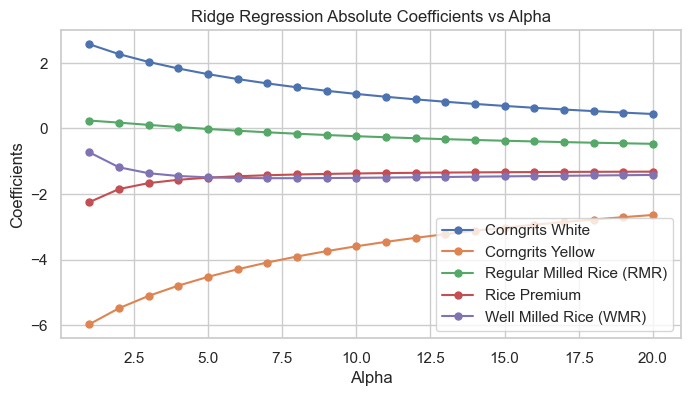

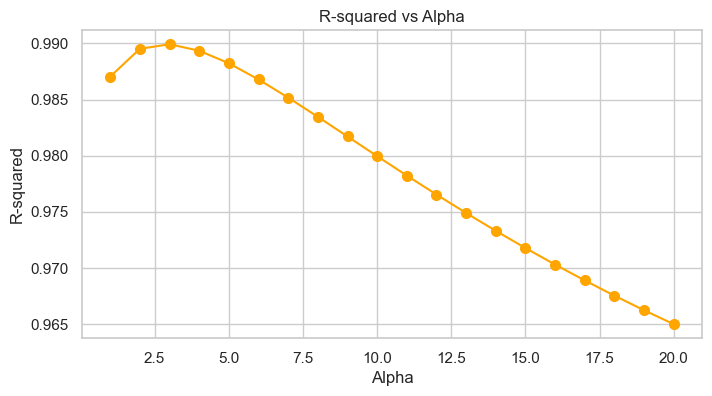

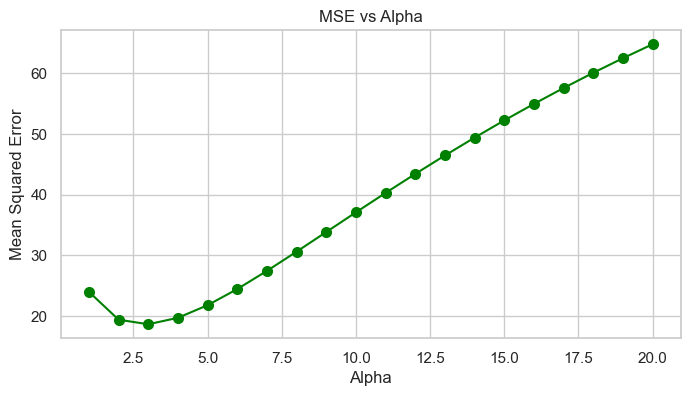

In [ ]:
# Initialize alpha values from 1 to 20
alphas = np.arange(1, 21)
coefficients = []
r2_values = []
mse_values = []

# Fit Ridge Regression for each alpha value
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(features_train, target_train)

    # Coefficients
    coefficients.append(ridge_model.coef_)

    # R-squared
    predictions = ridge_model.predict(features_test)
    r2_values.append(r2_score(target_test, predictions))

    # Mean Squared Error
    mse_values.append(mean_squared_error(target_test, predictions))

# Convert the lists into numpy arrays for easy plotting
coefficients = np.array(coefficients)
r2_values = np.array(r2_values)
mse_values = np.array(mse_values)

# Plot Absolute Values of Coefficients vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, coefficients, marker='o', markersize=5)
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Regression Absolute Coefficients vs Alpha')
plt.legend(features.columns)
plt.show()

# Plot R-squared vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, r2_values, marker='o', markersize=7, color='orange')
plt.xlabel('Alpha')
plt.ylabel('R-squared')
plt.title('R-squared vs Alpha')
plt.show()

# Plot MSE vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, mse_values, marker='o', markersize=7, color='green')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha')
plt.show()

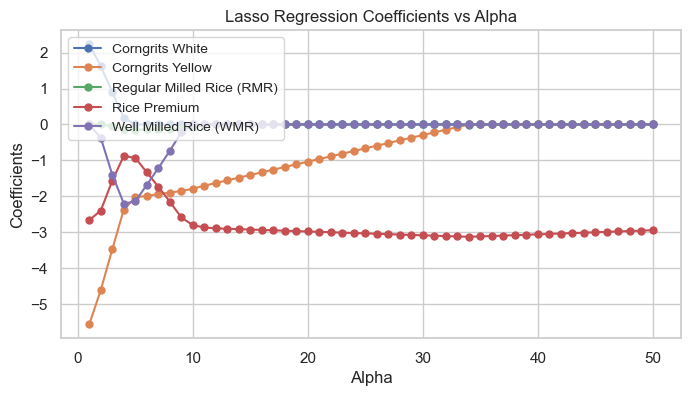

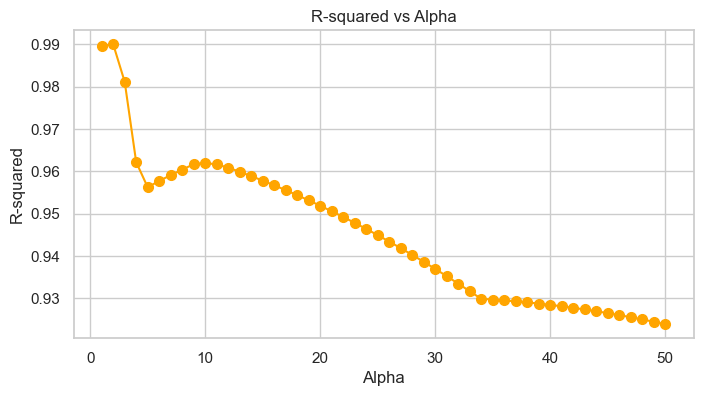

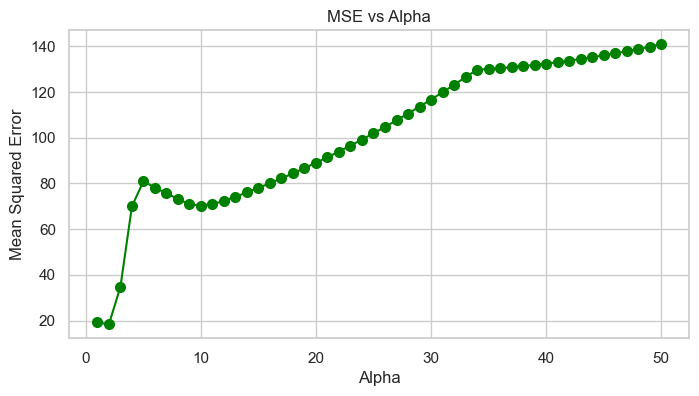

In [ ]:
# Initialize alpha values from 1 to 50
alphas = np.arange(1, 51)
coefficients = []
r2_values = []
mse_values = []

# Fit Lasso Regression for each alpha value
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(features_train, target_train)

    # Coefficients
    coefficients.append(lasso_model.coef_)

    # R-squared
    predictions = lasso_model.predict(features_test)
    r2_values.append(r2_score(target_test, predictions))

    # Mean Squared Error
    mse_values.append(mean_squared_error(target_test, predictions))

# Convert the lists into numpy arrays for easy plotting
coefficients = np.array(coefficients)
r2_values = np.array(r2_values)
mse_values = np.array(mse_values)

# Plot Coefficients vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, coefficients, marker='o', markersize=5)
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Regression Coefficients vs Alpha')

# Make the legend smaller and relocate it to the top-left corner
plt.legend(features.columns, loc='upper left', fontsize='small')

plt.show()

# Plot R-squared vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, r2_values, marker='o', markersize=7, color='orange')
plt.xlabel('Alpha')
plt.ylabel('R-squared')
plt.title('R-squared vs Alpha')
plt.show()

# Plot MSE vs Alpha
plt.figure(figsize=(8, 4))
plt.plot(alphas, mse_values, marker='o', markersize=7, color='green')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha')
plt.show()

In [ ]:
# alpha seems to be best here for quite low values, ~10

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)
linear_predictions = linear_model.predict(features_test)

# Ridge Regression
ridge_model = Ridge(alpha=10)  # You can adjust the alpha parameter
ridge_model.fit(features_train, target_train)
ridge_predictions = ridge_model.predict(features_test)

# Lasso Regression
lasso_model = Lasso(alpha=10)  # You can adjust the alpha parameter
lasso_model.fit(features_train, target_train)
lasso_predictions = lasso_model.predict(features_test)

# Evaluate the models
linear_mse = mean_squared_error(target_test, linear_predictions)
ridge_mse = mean_squared_error(target_test, ridge_predictions)
lasso_mse = mean_squared_error(target_test, lasso_predictions)

linear_r2 = r2_score(target_test, linear_predictions)
ridge_r2 = r2_score(target_test, ridge_predictions)
lasso_r2 = r2_score(target_test, lasso_predictions)

# List Coeffcients
linear_coeffs = linear_model.coef_
ridge_coeffs = ridge_model.coef_
lasso_coeffs = lasso_model.coef_

# Display Results
print("Linear Regression:")
print(f'Mean Squared Error: {linear_mse}')
print(f'R-squared: {linear_r2}')
print(f'Coefficients: {linear_coeffs}\n')

print("Ridge Regression:")
print(f'Mean Squared Error: {ridge_mse}')
print(f'R-squared: {ridge_r2}')
print(f'Coefficients: {ridge_coeffs}\n')

print("Lasso Regression:")
print(f'Mean Squared Error: {lasso_mse}')
print(f'R-squared: {lasso_r2}')
print(f'Coefficients: {lasso_coeffs}\n')

Linear Regression:
Mean Squared Error: 43.94378645648468
R-squared: 0.9762532879043092
Coefficients: [ 3.05050173 -6.81920018  0.22376456 -3.7244656   1.13140757]

Ridge Regression:
Mean Squared Error: 37.088041086507005
R-squared: 0.9799580531198292
Coefficients: [ 1.05455029 -3.59265807 -0.23483299 -1.37153686 -1.50525083]

Lasso Regression:
Mean Squared Error: 70.34051545767733
R-squared: 0.9619888019688513
Coefficients: [-0.         -1.79035767 -0.08381702 -2.80679442 -0.        ]



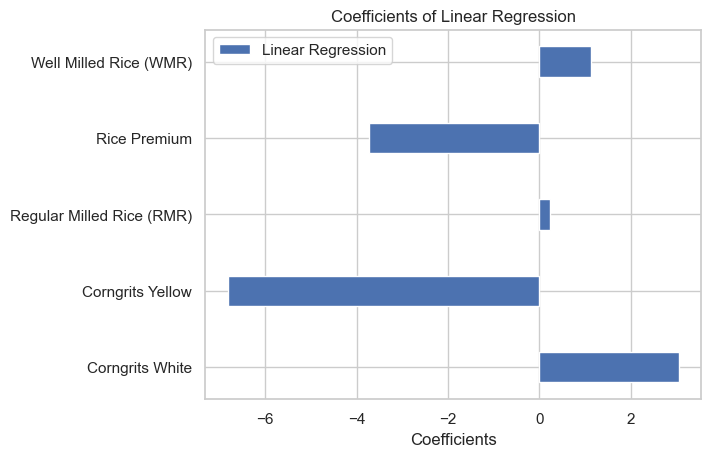

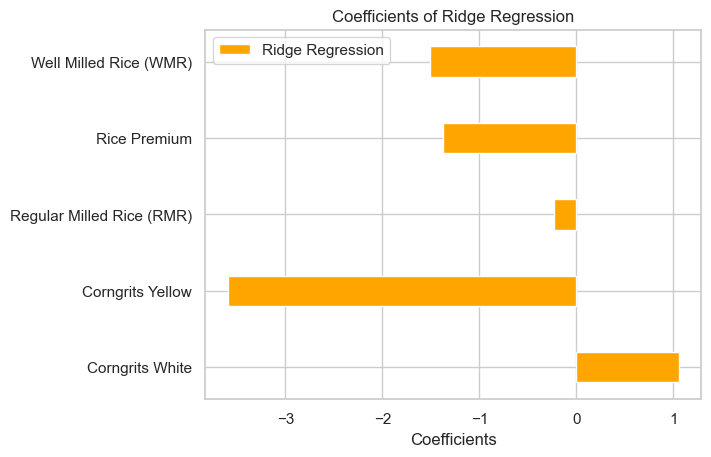

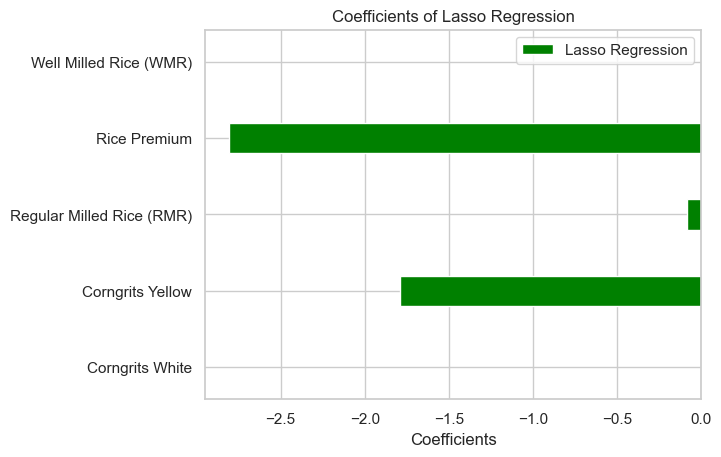

In [ ]:
# Plot Coefficients - Linear Regression
labels = features.columns
y = np.arange(len(labels))

fig, ax = plt.subplots()
ax.barh(y, linear_coeffs, 0.4, label='Linear Regression')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Coefficients')
ax.set_title('Coefficients of Linear Regression')
ax.legend()
plt.show()

# Plot Coefficients - Ridge Regression
fig, ax = plt.subplots()
ax.barh(y, ridge_coeffs, 0.4, label='Ridge Regression', color='orange')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Coefficients')
ax.set_title('Coefficients of Ridge Regression')
ax.legend()
plt.show()

# Plot Coefficients - Lasso Regression
fig, ax = plt.subplots()
ax.barh(y, lasso_coeffs, 0.4, label='Lasso Regression', color='green')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlabel('Coefficients')
ax.set_title('Coefficients of Lasso Regression')
ax.legend()
plt.show()

This first exploratory use of the regression models have given us some interesting insights and guidelines for the major regressions we will use later on
1. The value of alpha which generally describes the degree to which the regression models simplify themselves depends based on the type of good but a value between 10 - 20 is appropriate
2. The basic linear regression provides the least accurate model
3. Basic goods like grains and vegetables tend to be good indicators of GRDP per capita
4. More expensive seafood also contributesin describing GRDP per capita
5. There is quite a deal of regional difference


## 5.2 Regression by Region

We create some variables and functions to help with running the regressions on the whole dataset

In [ ]:
# Create region list for ease of indexing
REGION_LIST = ['..NATIONAL CAPITAL REGION (NCR)',
               '..CORDILLERA ADMINISTRATIVE REGION (CAR)',
               '..REGION I (ILOCOS REGION)',
               '..REGION II (CAGAYAN VALLEY)',
               '..REGION III (CENTRAL LUZON)',
               '..REGION IV-A (CALABARZON)',
               '..MIMAROPA REGION',
               '..REGION V (BICOL REGION)',
               '..REGION VI (WESTERN VISAYAS)',
               '..REGION VII (CENTRAL VISAYAS)',
               '..REGION VIII (EASTERN VISAYAS)',
               '..REGION IX (ZAMBOANGA PENINSULA)',
               '..REGION X (NORTHERN MINDANAO)',
               '..REGION XI (DAVAO REGION)',
               '..REGION XII (SOCCSKSARGEN)',
               '..REGION XIII (CARAGA)',
               '..AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)'
              ]

# Create wholesale good type list for ease of indexing
GOOD_TYPES = [
    cleaned_BeanAndLegumes,
    cleaned_Cereals,
    cleaned_CommercialCrops,
    cleaned_Condiments,
    cleaned_FruitVegetables,
    cleaned_Fruits,
    cleaned_LeafyVegetables,
    cleaned_Poultry,
    cleaned_Rootcrops,
    cleaned_Seafood
]

# Create variable for alpha in regressions
Alpha = 15

# Pick how many coefficients to show in plotting
top = 20

# Designate seed for consistency
seed = 20

# Designate train split portion (number between 0-1 which indicates the portion for testing)
split = 0.2


# Function to plot horizontal barplot with sign change indication and color differentiation
def plot_horizontal_barplot(coefficients, title):
    # Sort coefficients by absolute value in descending order
    sorted_coeffs = coefficients.abs().sort_values(ascending=False)
    top_coeffs = sorted_coeffs.head(top)

    # Check if the sign of the coefficient changes
    changed_sign = ['--' + label if coefficients[label] < 0 else label for label in top_coeffs.index]

    # Set colors based on the sign of the coefficient
    colors = ['red' if coefficients[label] < 0 else 'blue' for label in top_coeffs.index]

    # Plotting
    plt.barh(changed_sign, top_coeffs, color=colors)
    plt.xlabel('Absolute Coefficient Value')
    plt.title(title)
    plt.show()

### Addendum: How to read the bar charts
The next section will have a series of bar charts describing the wholesale goods which are good correlators with GRDP per capita. Here are a few notes regarding how to read and interpret them:
1. Blue indicates a positive correlation, this means that a higher price of the wholesale good correlates with higher GRDP per capita
2. Red indicates a negative correlation, this means that a lower price of the wholesale good correlates  with higher GRDP per capita
3. The R^2 and MSE values describe how accurate a model is: ideally we want higher R^2 and lower MSE
4. Lasso regression really does drop a lot of the variables to create a more simplified and generalizable model


R-squared and MSE values :
           ..NATIONAL CAPITAL REGION (NCR) Linear Regression  \
R-squared                                           0.535210   
MSE                                              2539.123665   

           ..NATIONAL CAPITAL REGION (NCR) Ridge Regression  \
R-squared                                          0.325327   
MSE                                             3685.704834   

           ..NATIONAL CAPITAL REGION (NCR) Lasso Regression  
R-squared                                          0.810202  
MSE                                             1036.856344  


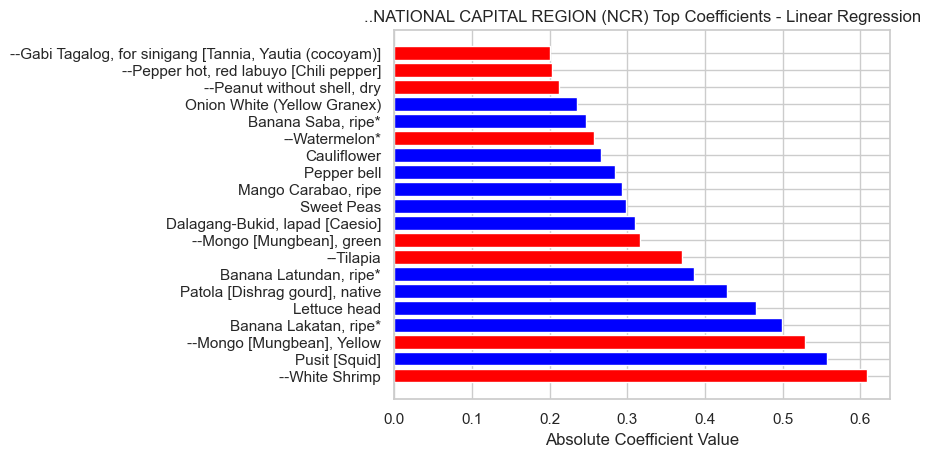

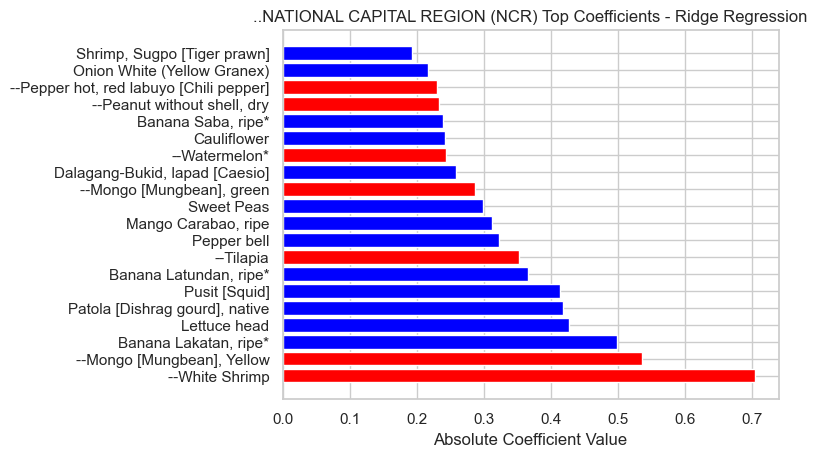

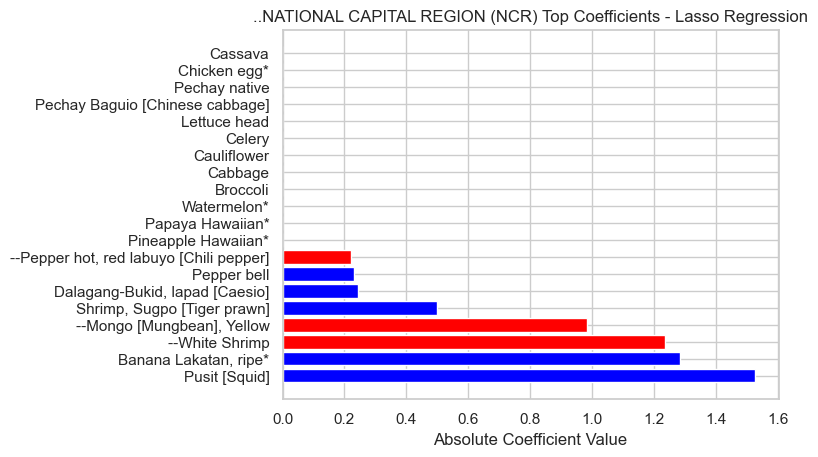


R-squared and MSE values :
           ..CORDILLERA ADMINISTRATIVE REGION (CAR) Linear Regression  \
R-squared                                           0.235146            
MSE                                               368.703694            

           ..CORDILLERA ADMINISTRATIVE REGION (CAR) Ridge Regression  \
R-squared                                           0.774975           
MSE                                               108.474948           

           ..CORDILLERA ADMINISTRATIVE REGION (CAR) Lasso Regression  
R-squared                                          -0.884520          
MSE                                               908.446748          


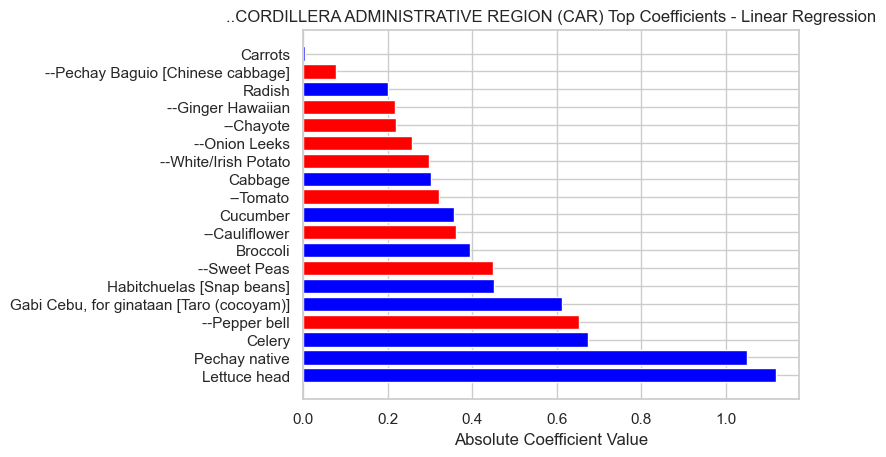

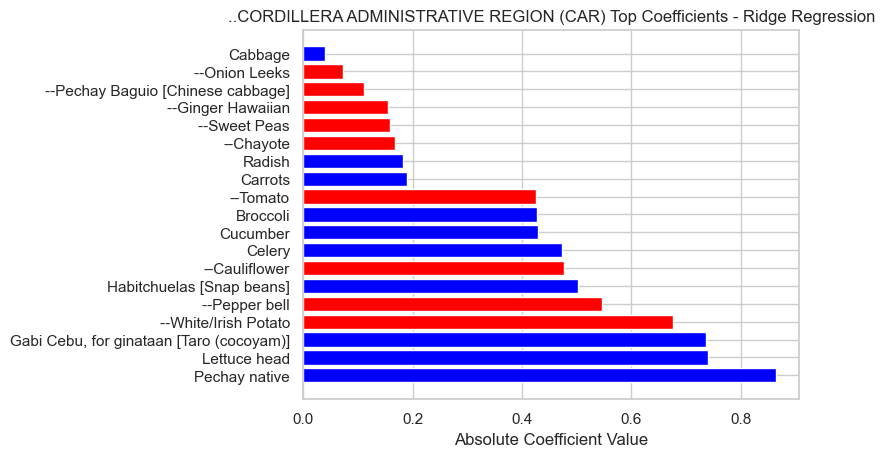

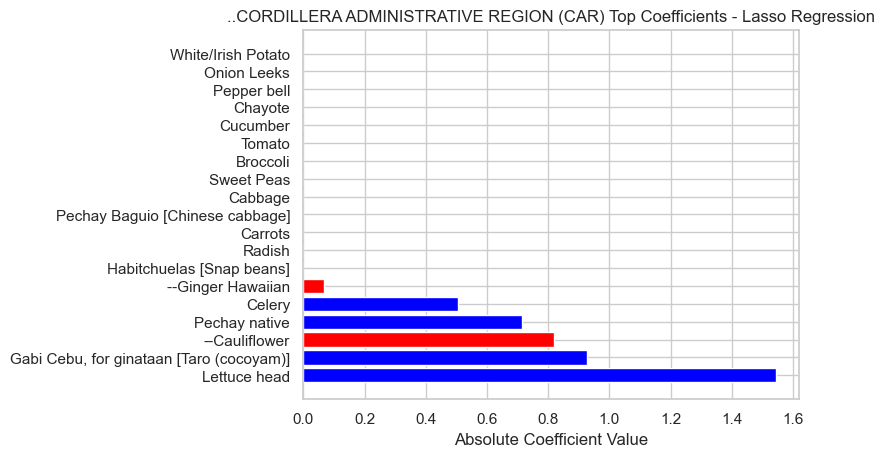


R-squared and MSE values :
           ..REGION I (ILOCOS REGION) Linear Regression  \
R-squared                                      0.808904   
MSE                                           65.988508   

           ..REGION I (ILOCOS REGION) Ridge Regression  \
R-squared                                     0.786970   
MSE                                          73.562556   

           ..REGION I (ILOCOS REGION) Lasso Regression  
R-squared                                     0.966622  
MSE                                          11.526040  


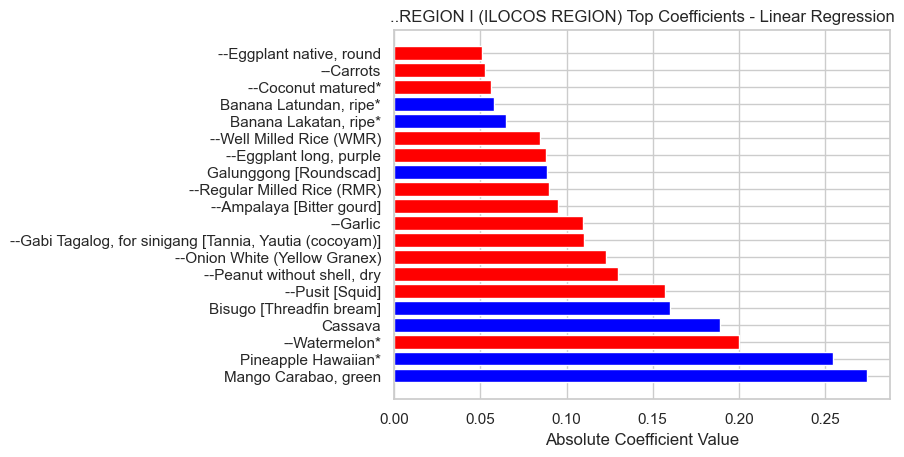

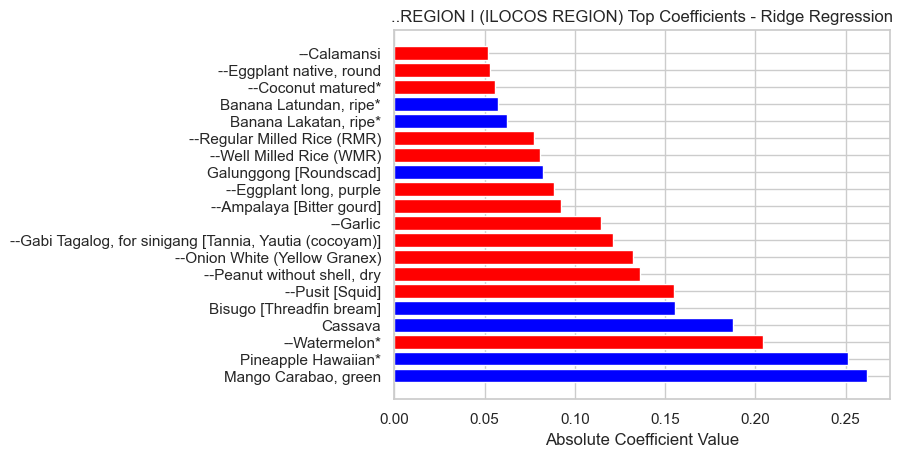

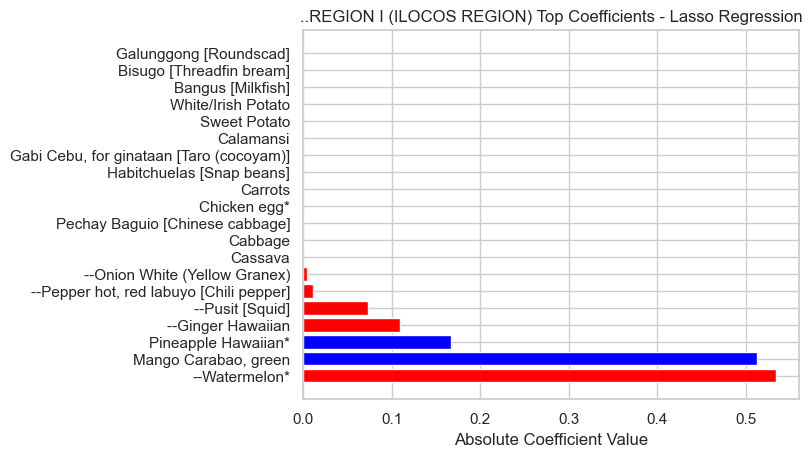


R-squared and MSE values :
           ..REGION II (CAGAYAN VALLEY) Linear Regression  \
R-squared                                        0.974337   
MSE                                              8.871991   

           ..REGION II (CAGAYAN VALLEY) Ridge Regression  \
R-squared                                       0.906827   
MSE                                            32.211456   

           ..REGION II (CAGAYAN VALLEY) Lasso Regression  
R-squared                                       0.984104  
MSE                                             5.495355  


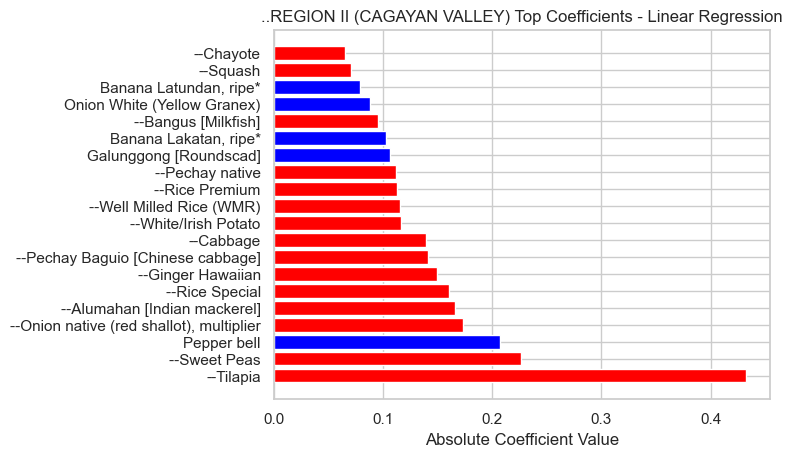

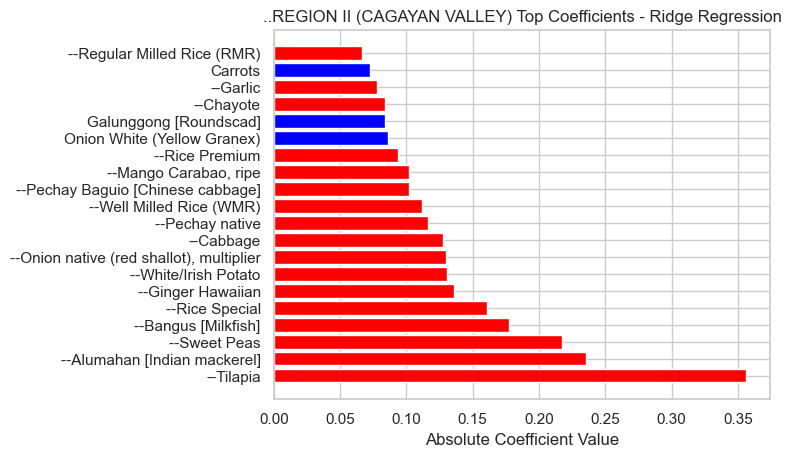

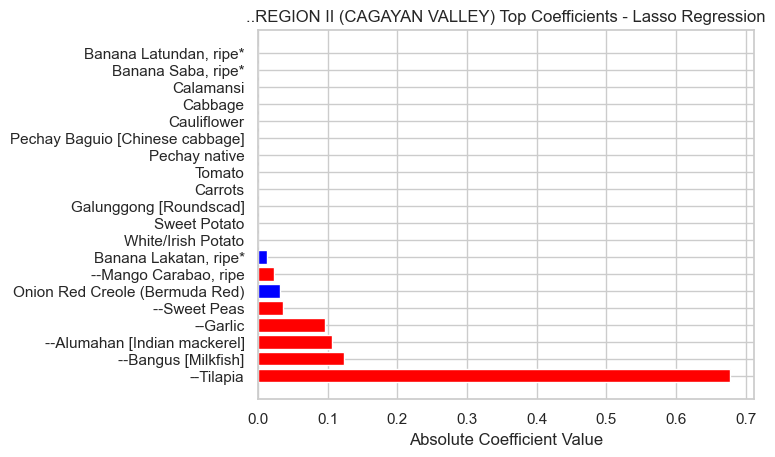


R-squared and MSE values :
           ..REGION III (CENTRAL LUZON) Linear Regression  \
R-squared                                       -0.878211   
MSE                                           1560.647589   

           ..REGION III (CENTRAL LUZON) Ridge Regression  \
R-squared                                      -0.766561   
MSE                                          1467.875265   

           ..REGION III (CENTRAL LUZON) Lasso Regression  
R-squared                                       0.636901  
MSE                                           301.707012  


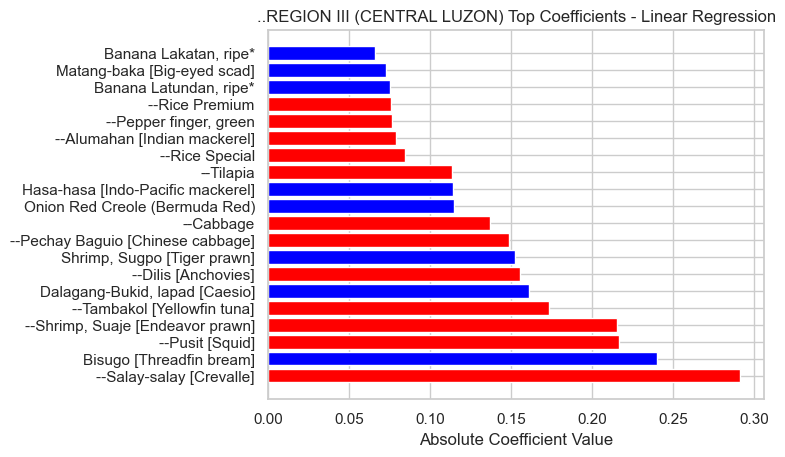

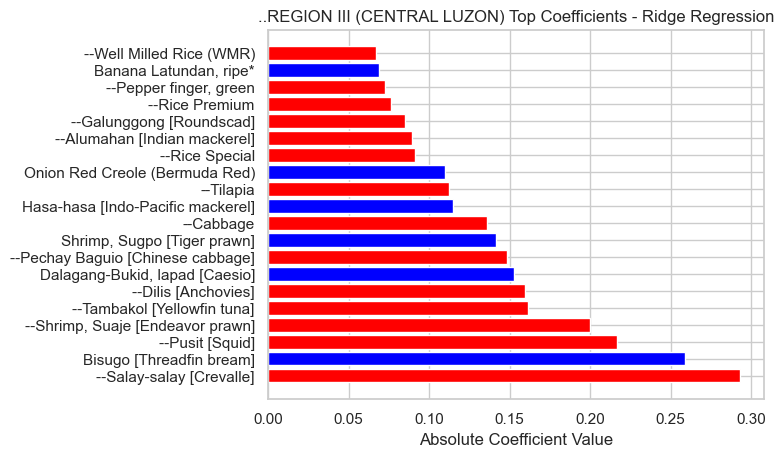

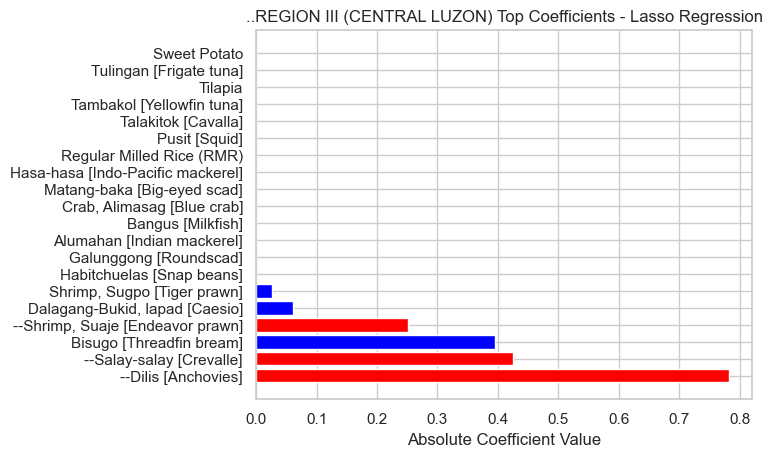


R-squared and MSE values :
           ..REGION IV-A (CALABARZON) Linear Regression  \
R-squared                                      0.541517   
MSE                                          227.415318   

           ..REGION IV-A (CALABARZON) Ridge Regression  \
R-squared                                     0.464276   
MSE                                         265.728279   

           ..REGION IV-A (CALABARZON) Lasso Regression  
R-squared                                     0.714873  
MSE                                         141.427937  


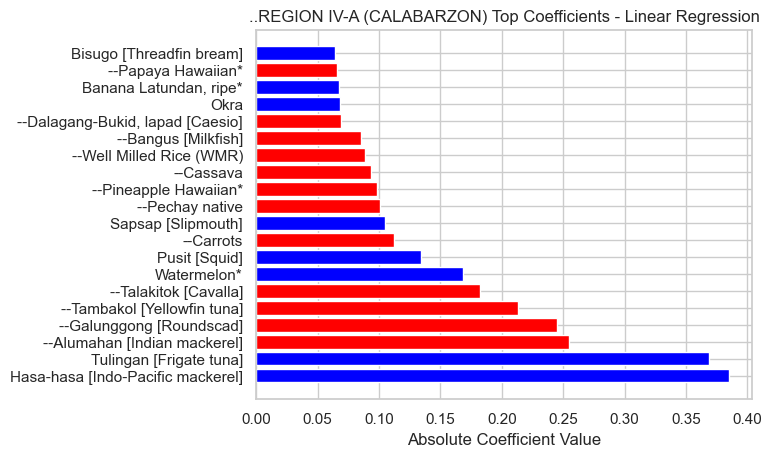

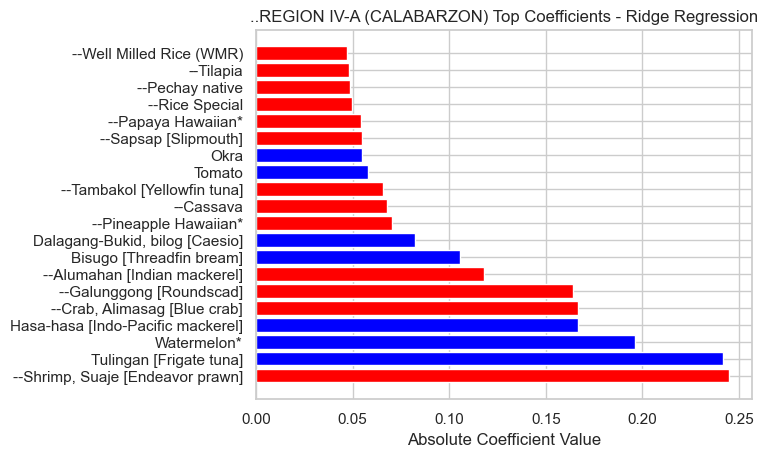

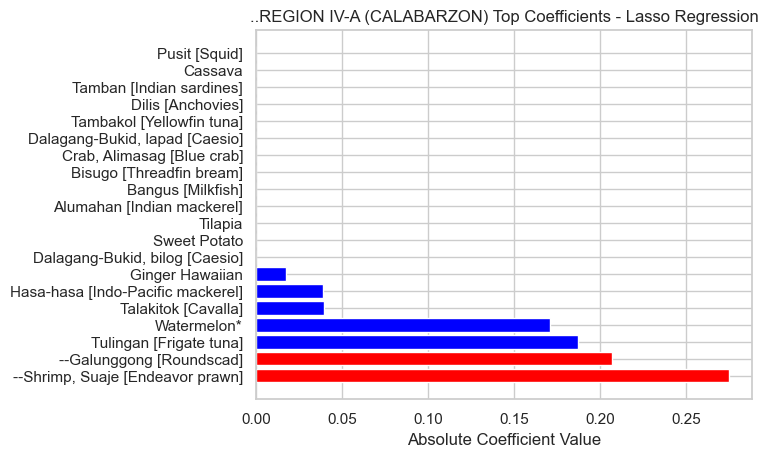


R-squared and MSE values :
           ..MIMAROPA REGION Linear Regression  \
R-squared                             0.816040   
MSE                                  58.052603   

           ..MIMAROPA REGION Ridge Regression  \
R-squared                            0.806374   
MSE                                 61.102775   

           ..MIMAROPA REGION Lasso Regression  
R-squared                            0.831883  
MSE                                 53.052906  


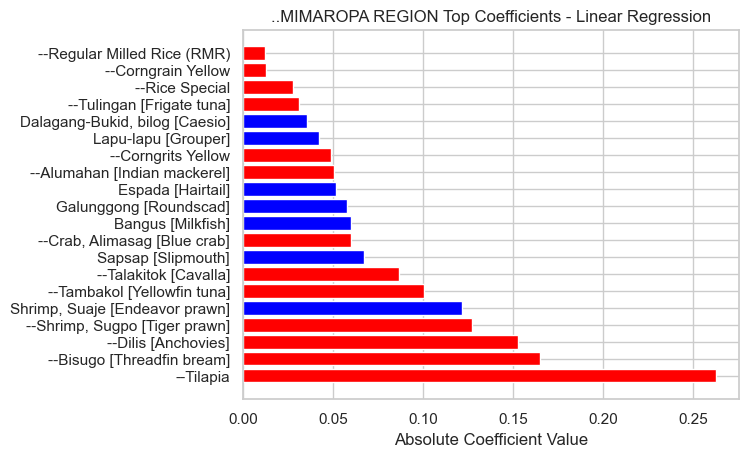

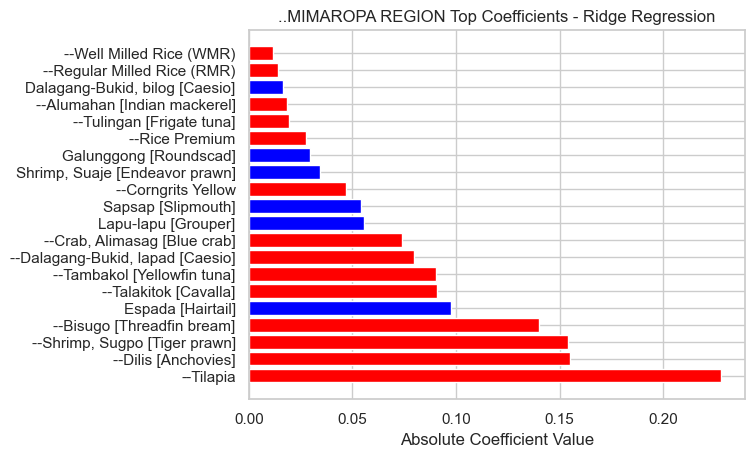

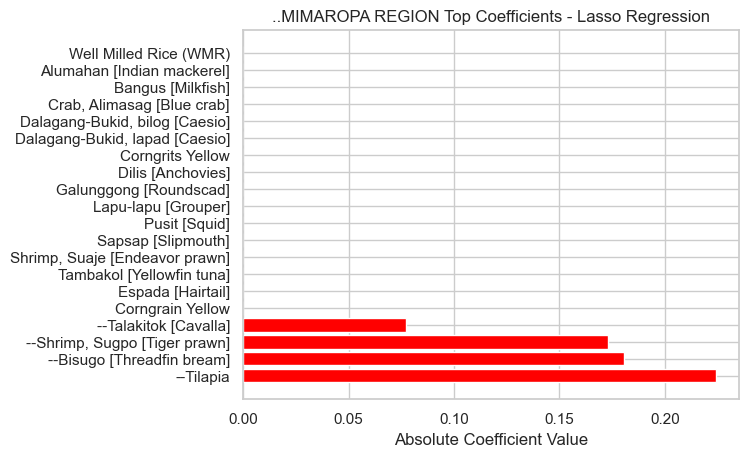


R-squared and MSE values :
           ..REGION V (BICOL REGION) Linear Regression  \
R-squared                                     0.658338   
MSE                                          95.063750   

           ..REGION V (BICOL REGION) Ridge Regression  \
R-squared                                    0.673646   
MSE                                         90.804642   

           ..REGION V (BICOL REGION) Lasso Regression  
R-squared                                    0.709415  
MSE                                         80.852081  


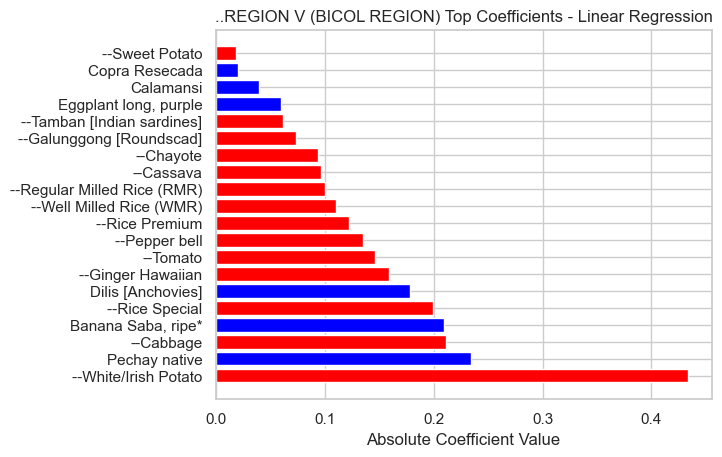

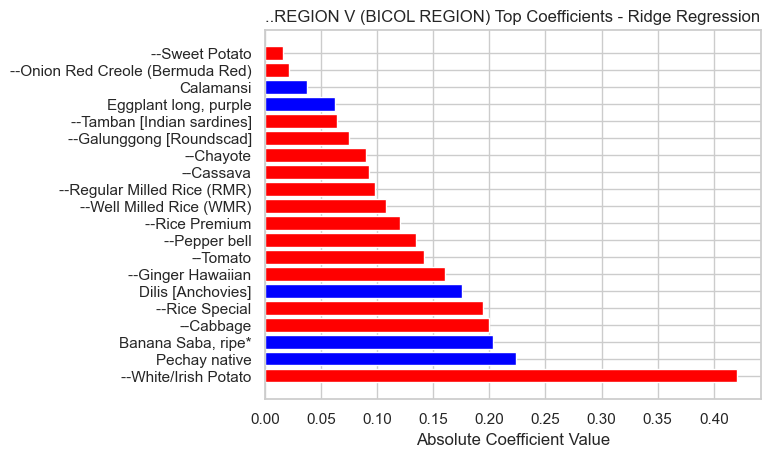

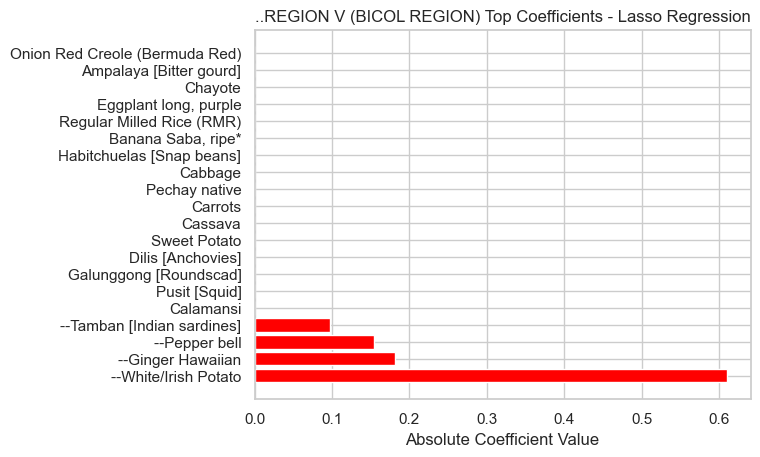


R-squared and MSE values :
           ..REGION VI (WESTERN VISAYAS) Linear Regression  \
R-squared                                        -2.126016   
MSE                                             303.294935   

           ..REGION VI (WESTERN VISAYAS) Ridge Regression  \
R-squared                                       -2.072494   
MSE                                            298.102071   

           ..REGION VI (WESTERN VISAYAS) Lasso Regression  
R-squared                                       -3.031974  
MSE                                            391.193561  


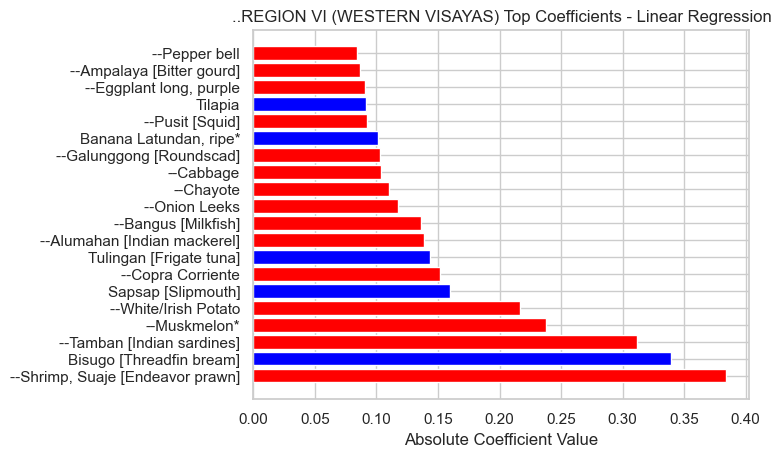

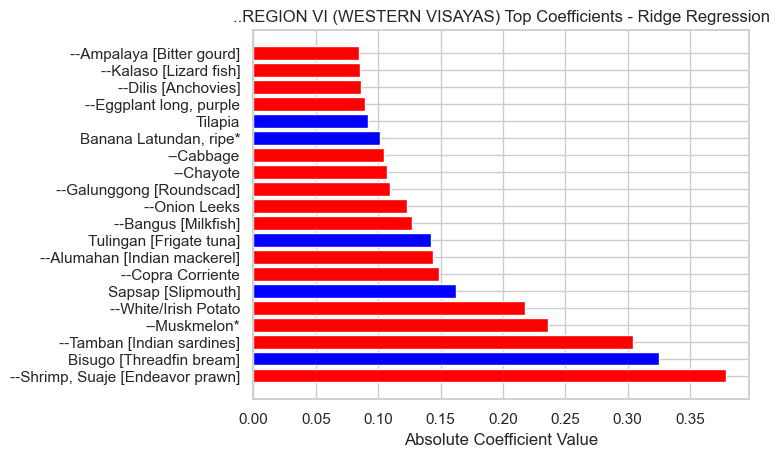

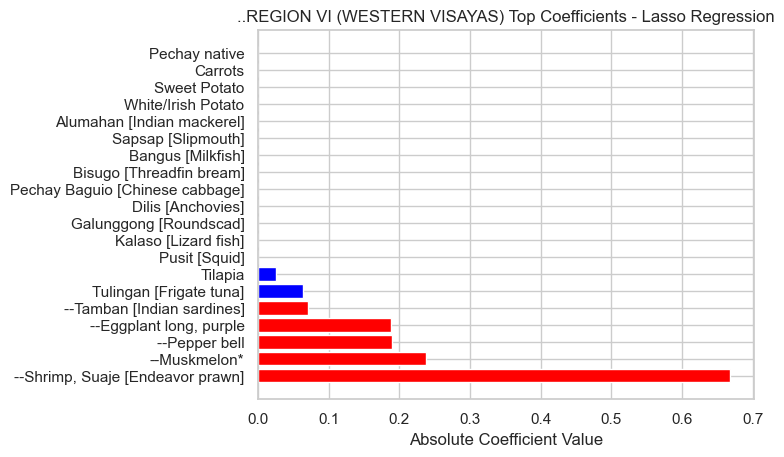


R-squared and MSE values :
           ..REGION VII (CENTRAL VISAYAS) Linear Regression  \
R-squared                                          0.897802   
MSE                                               66.265922   

           ..REGION VII (CENTRAL VISAYAS) Ridge Regression  \
R-squared                                         0.973231   
MSE                                              17.357331   

           ..REGION VII (CENTRAL VISAYAS) Lasso Regression  
R-squared                                         0.935463  
MSE                                              41.846136  


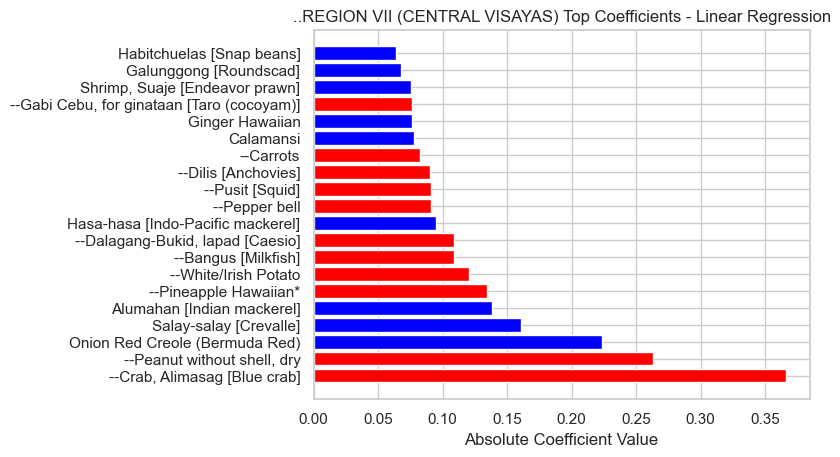

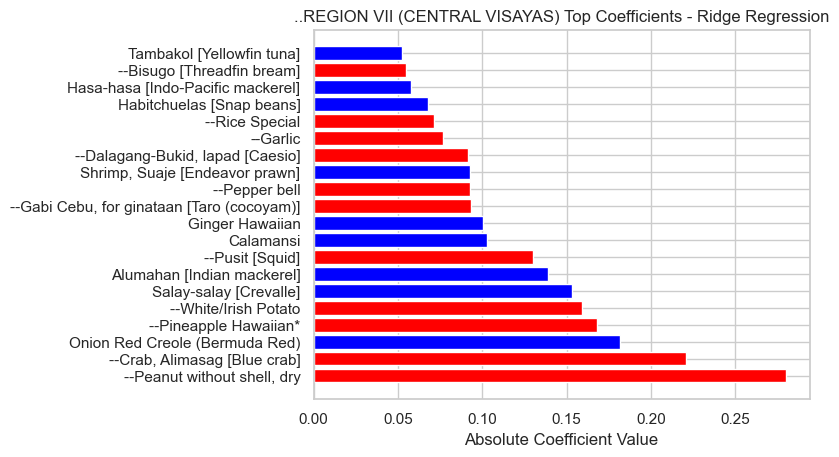

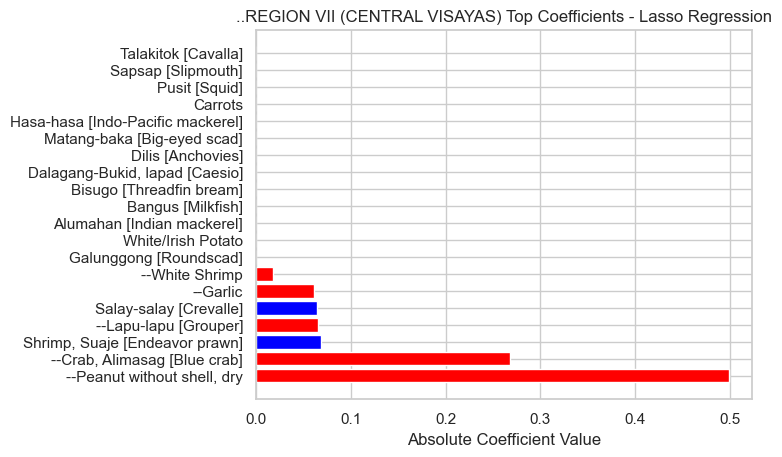


R-squared and MSE values :
           ..REGION VIII (EASTERN VISAYAS) Linear Regression  \
R-squared                                           0.854593   
MSE                                                28.209202   

           ..REGION VIII (EASTERN VISAYAS) Ridge Regression  \
R-squared                                          0.639762   
MSE                                               69.886502   

           ..REGION VIII (EASTERN VISAYAS) Lasso Regression  
R-squared                                          0.609649  
MSE                                               75.728544  


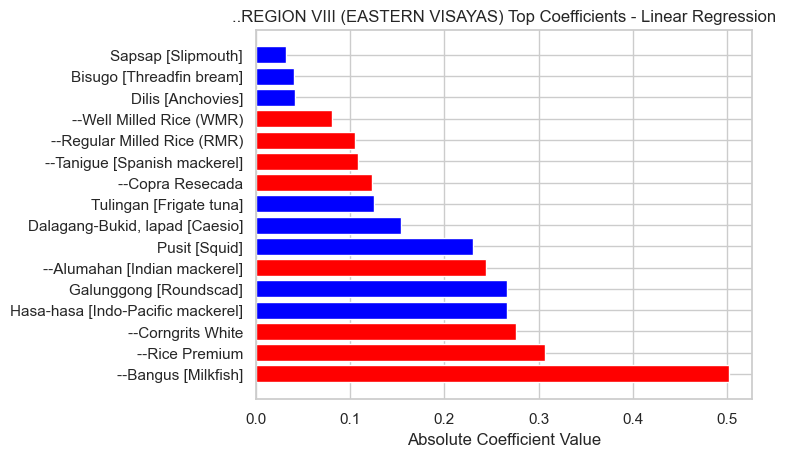

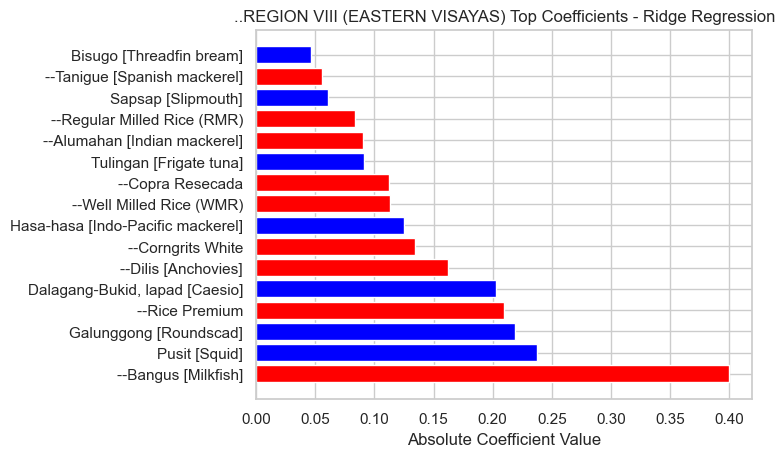

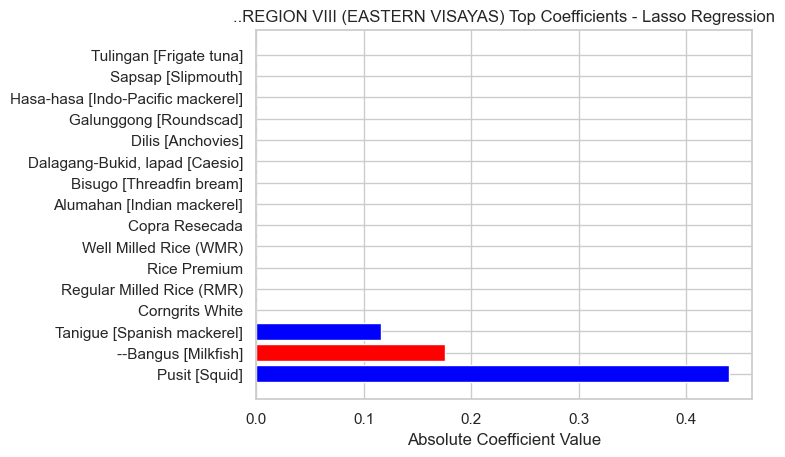


R-squared and MSE values :
           ..REGION IX (ZAMBOANGA PENINSULA) Linear Regression  \
R-squared                                          -0.100132     
MSE                                               320.522829     

           ..REGION IX (ZAMBOANGA PENINSULA) Ridge Regression  \
R-squared                                           0.136712    
MSE                                               251.518689    

           ..REGION IX (ZAMBOANGA PENINSULA) Lasso Regression  
R-squared                                           0.705331   
MSE                                                85.851551   


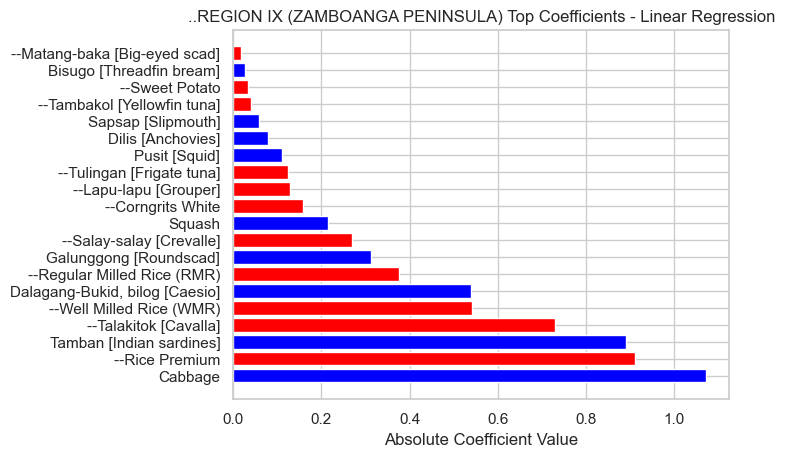

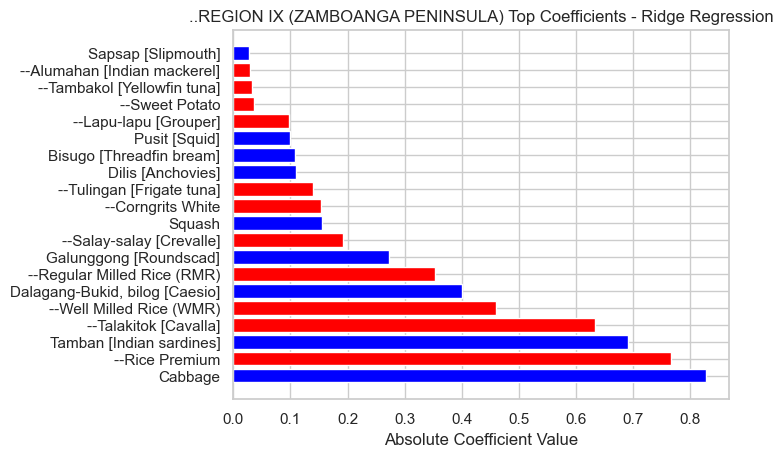

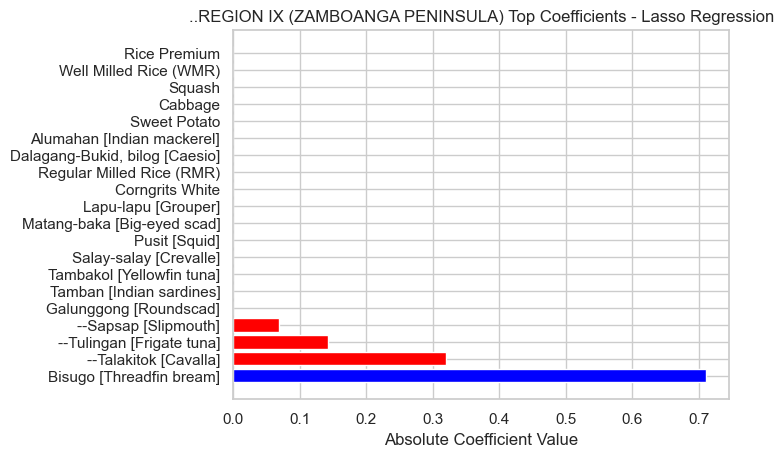


R-squared and MSE values :
           ..REGION X (NORTHERN MINDANAO) Linear Regression  \
R-squared                                          0.809675   
MSE                                              163.158831   

           ..REGION X (NORTHERN MINDANAO) Ridge Regression  \
R-squared                                         0.900764   
MSE                                              85.071311   

           ..REGION X (NORTHERN MINDANAO) Lasso Regression  
R-squared                                         0.837603  
MSE                                             139.217174  


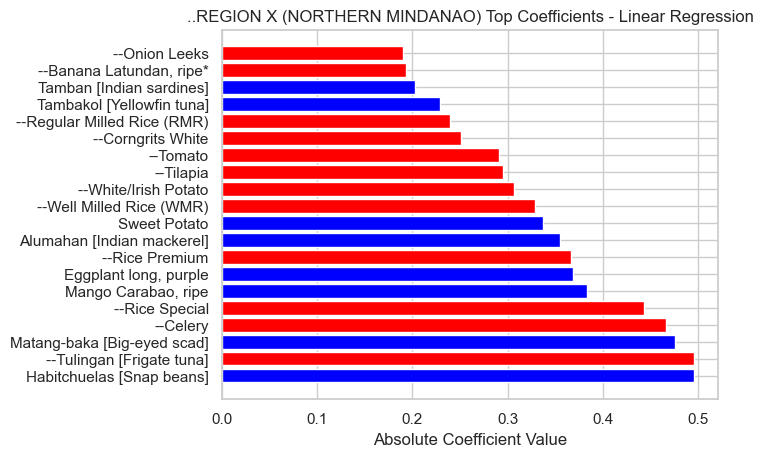

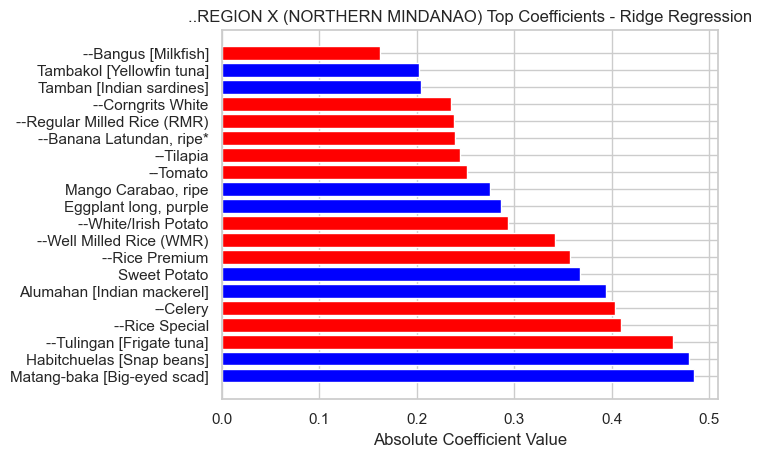

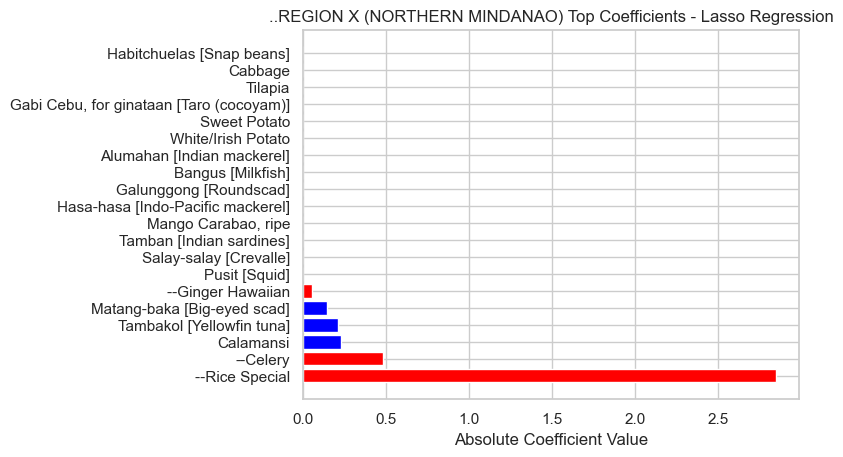


R-squared and MSE values :
           ..REGION XI (DAVAO REGION) Linear Regression  \
R-squared                                      0.921612   
MSE                                           67.597535   

           ..REGION XI (DAVAO REGION) Ridge Regression  \
R-squared                                     0.929898   
MSE                                          60.451953   

           ..REGION XI (DAVAO REGION) Lasso Regression  
R-squared                                     0.842684  
MSE                                         135.660999  


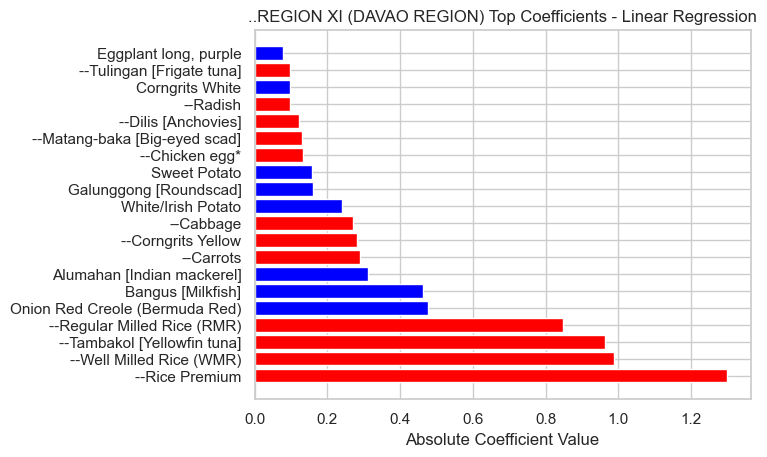

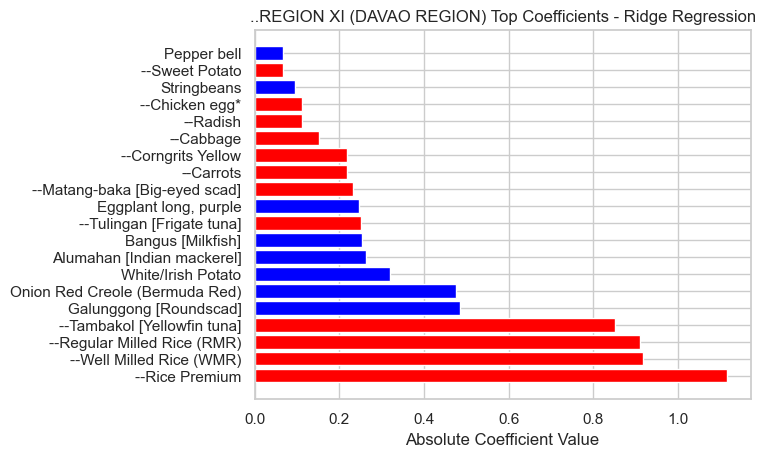

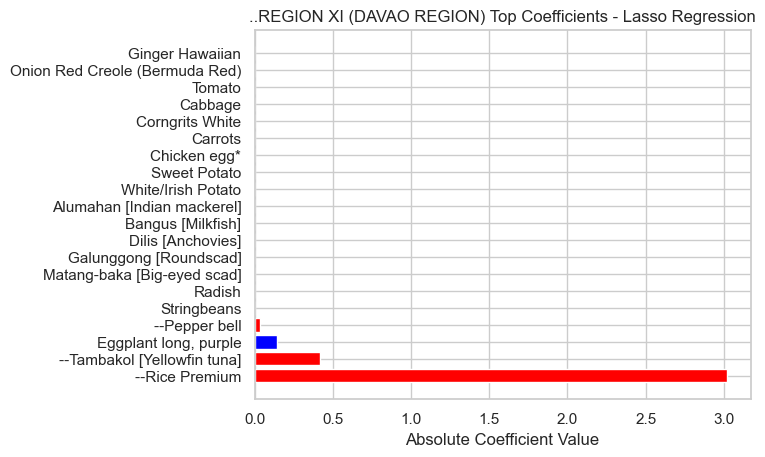


R-squared and MSE values :
           ..REGION XII (SOCCSKSARGEN) Linear Regression  \
R-squared                                       0.888853   
MSE                                            18.015590   

           ..REGION XII (SOCCSKSARGEN) Ridge Regression  \
R-squared                                      0.910414   
MSE                                           14.520953   

           ..REGION XII (SOCCSKSARGEN) Lasso Regression  
R-squared                                      0.590844  
MSE                                           66.319536  


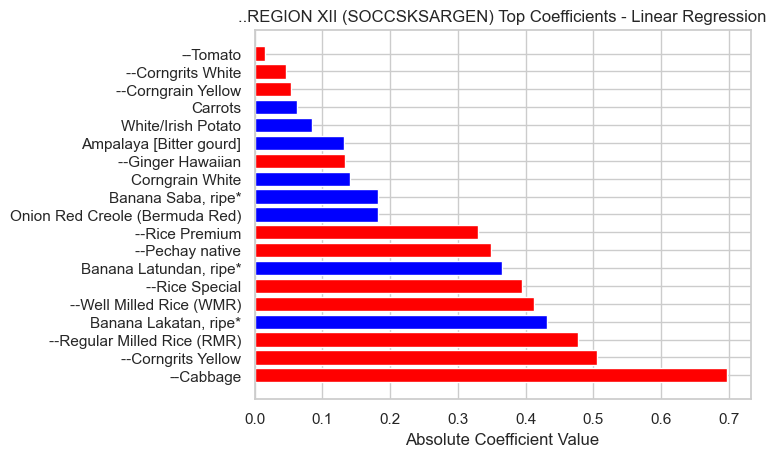

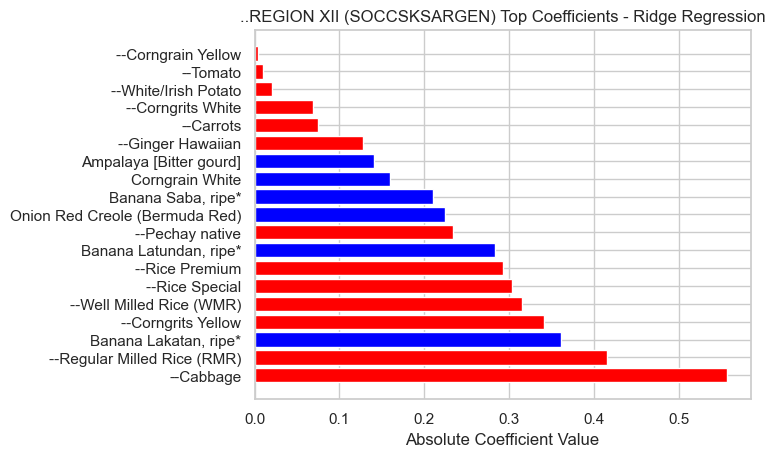

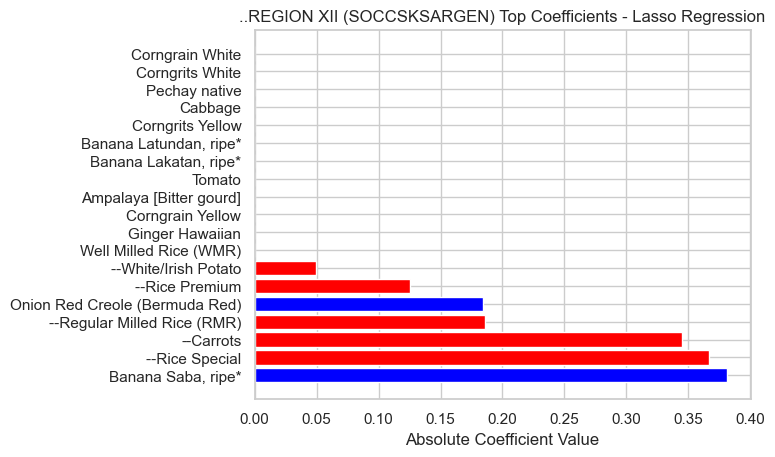


R-squared and MSE values :
           ..REGION XIII (CARAGA) Linear Regression  \
R-squared                                  0.924502   
MSE                                       28.201520   

           ..REGION XIII (CARAGA) Ridge Regression  \
R-squared                                 0.952090   
MSE                                      17.896245   

           ..REGION XIII (CARAGA) Lasso Regression  
R-squared                                 0.922456  
MSE                                      28.965772  


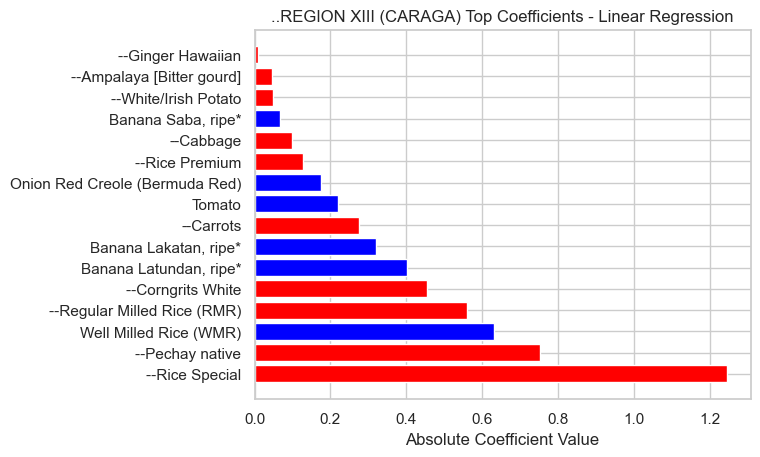

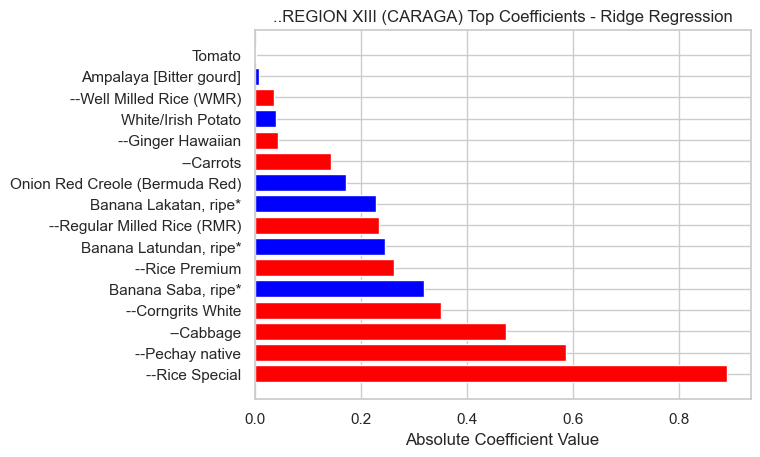

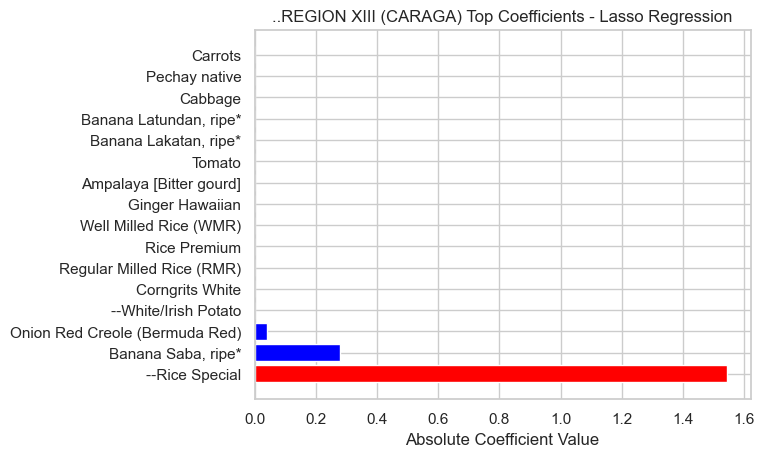


R-squared and MSE values :
           ..AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM) Linear Regression  \
R-squared                                           0.339047                 
MSE                                                24.296252                 

           ..AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM) Ridge Regression  \
R-squared                                           0.527060                
MSE                                                17.385011                

           ..AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM) Lasso Regression  
R-squared                                           0.902254               
MSE                                                 3.593093               


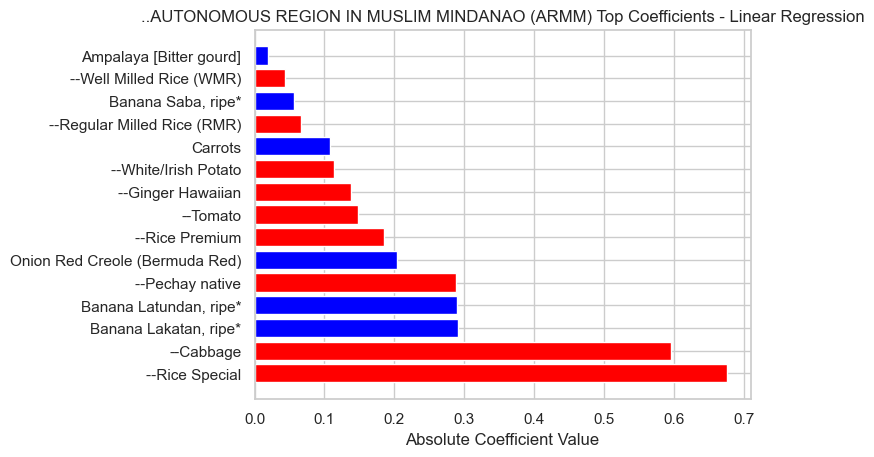

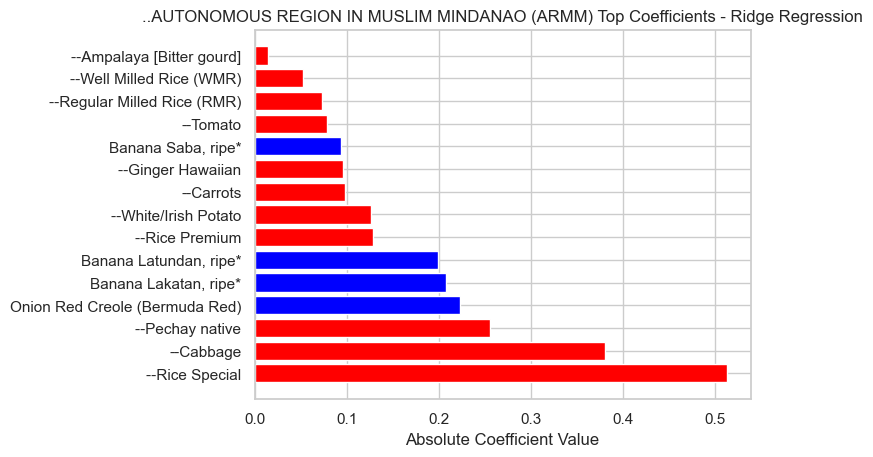

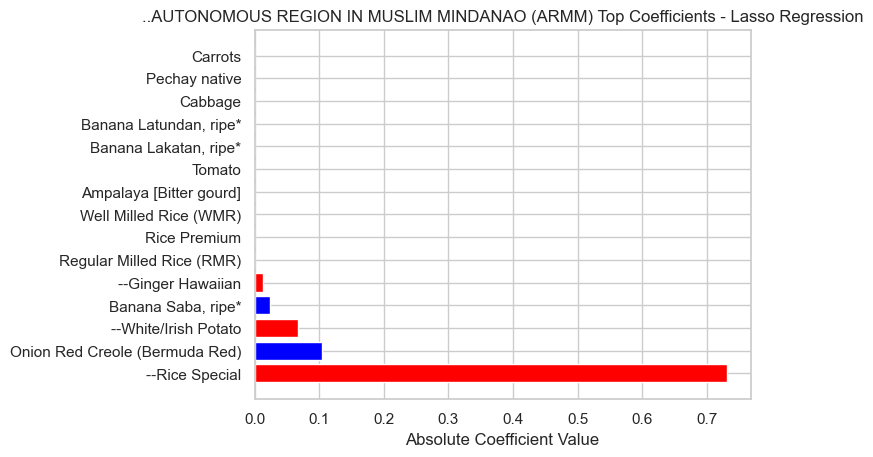

In [ ]:
# Create loop to perform analysis across the whole dataset

region_regression_metrics = pd.DataFrame()
region_regression_best = pd.DataFrame()

for REGION in REGION_LIST:

    region_data = pd.DataFrame()

    # Set up dataframe for regression
    for GOOD in GOOD_TYPES:

        try:

            group = GOOD.groupby('Geolocation')

            good_data = pd.pivot_table(group.get_group(REGION), values = YEARS, index = 'Commodity').transpose()

            good_data.reset_index(drop=True, inplace=True)

            region_data = pd.concat([region_data, good_data], axis=1)

        except:

            pass

    # Append GRDP and GRDP per capita data to dataframe
    region_data = pd.concat([region_data, GRDPs[REGION]], axis=1)
    region_data.columns = list(region_data.columns[:-1]) + ['GRDP']

    region_data = pd.concat([region_data, GRDP_percapita[REGION]], axis=1)
    region_data.columns = list(region_data.columns[:-1]) + ['GRDP per capita']

    region_data.index = YEARS
    region_data.index.name='Year'
    region_data = region_data.fillna(region_data.mean())

    # Implement regression models
    # Separate features and target variable
    features = region_data.iloc[:, :-2]
    target = region_data['GRDP per capita']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=split, random_state=seed)

    # Initialize models
    linear_reg = LinearRegression()
    ridge_reg = Ridge(alpha=Alpha)
    lasso_reg = Lasso(alpha=Alpha)

    # Fit models
    linear_reg.fit(X_train, y_train)
    ridge_reg.fit(X_train, y_train)
    lasso_reg.fit(X_train, y_train)

    # Predictions
    y_pred_linear = linear_reg.predict(X_test)
    y_pred_ridge = ridge_reg.predict(X_test)
    y_pred_lasso = lasso_reg.predict(X_test)

    # Coefficients
    coefficients_df = pd.DataFrame({
        'Linear Regression': linear_reg.coef_,
        'Ridge Regression': ridge_reg.coef_,
        'Lasso Regression': lasso_reg.coef_
    }, index=features.columns)

    # R-squared and MSE values
    metrics_df = pd.DataFrame({
        REGION+' Linear Regression': [r2_score(y_test, y_pred_linear), mean_squared_error(y_test, y_pred_linear)],
        REGION+' Ridge Regression': [r2_score(y_test, y_pred_ridge), mean_squared_error(y_test, y_pred_ridge)],
        REGION+' Lasso Regression': [r2_score(y_test, y_pred_lasso), mean_squared_error(y_test, y_pred_lasso)]
    }, index=['R-squared', 'MSE'])

    max_column = metrics_df.iloc[0].idxmax()

    # Create a new DataFrame with the column containing the highest value
    max_df = pd.DataFrame({max_column: metrics_df[max_column]})

    region_regression_best = pd.concat([region_regression_best, max_df], axis=1)

    # Display results
    print("\nR-squared and MSE values :")
    print(metrics_df)

    # Plotting for each regression model
    for model_name, model_coeffs in coefficients_df.items():
        plot_horizontal_barplot(model_coeffs, REGION+f' Top Coefficients - {model_name}')

    region_regression_metrics = pd.concat([region_regression_metrics, metrics_df], axis=1)

    # Save dataframes and figures to files
    coefficients_df.to_csv(REGION+' coefficients.csv')


In [ ]:
# Lets look at a summary of our findings
region_regression_best.transpose()

R-squared          MSE
..NATIONAL CAPITAL REGION (NCR) Lasso Regression     0.810202  1036.856344
..CORDILLERA ADMINISTRATIVE REGION (CAR) Ridge ...   0.774975   108.474948
..REGION I (ILOCOS REGION) Lasso Regression          0.966622    11.526040
..REGION II (CAGAYAN VALLEY) Lasso Regression        0.984104     5.495355
..REGION III (CENTRAL LUZON) Lasso Regression        0.636901   301.707012
..REGION IV-A (CALABARZON) Lasso Regression          0.714873   141.427937
..MIMAROPA REGION Lasso Regression                   0.831883    53.052906
..REGION V (BICOL REGION) Lasso Regression           0.709415    80.852081
..REGION VI (WESTERN VISAYAS) Ridge Regression      -2.072494   298.102071
..REGION VII (CENTRAL VISAYAS) Ridge Regression      0.973231    17.357331
..REGION VIII (EASTERN VISAYAS) Linear Regression    0.854593    28.209202
..REGION IX (ZAMBOANGA PENINSULA) Lasso Regression   0.705331    85.851551
..REGION X (NORTHERN MINDANAO) Ridge Regression      0.900764    85.071311
..REGION XI (DAVAO REGION) Ridge Regression          0.929898    60.451953
..REGION XII (SOCCSKSARGEN) Ridge Regression         0.910414    14.520953
..REGION XIII (CARAGA) Ridge Regression              0.952090    17.896245
..AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM) L...   0.902254     3.593093

## Key takeaways for this section
### General Takeaways
1. The indicators for GRDP are are vastly different depending on region
2. All three regression models are needed to describe accurately a region because of regional differences
3. Prices of grains and cereals like rice almost always negatively correlated with GRDP per capita in rural regions. This indicates that the cheaper they are, the higher people's GRDP per capita is.

### Regional Takeaways
1. NCR - The level of wealth allows for many types of goods to be good indicators of GRDP per capita
2. CAR - Vegetables prices are particularly good indicators
3. REGION I - Fruits are positive correlators while vegetables are negative correlators
4. REGION II - Mostly negative correlators, particular vegetables and seafood
5. REGION III - Highly dependent on Seafood
6. REGION IVA - Highly dependent on Seafood
7. REGION IVB (MIMAROPA) - Highly dependent on Seafood
8. REGION V - Good correlators are rootcrops and vegetables
9. REGION VI - All the R^2 values are low suggesting that any correlations drawn from the model highly likely to be inaccurate
10. REGION VII - Highly dependent on Seafood
11. REGION IX - Highly dependent on Seafood
12. REGION X - Highly diversified indicators with no single wholesale good being a dominant correlator
13. REGION XI - Heavily influenced by grain and seafood prices
14. REGION XII - Rice and fruit based correlations
16. REGION XIII - Heavily influenced by grain and vegetable prices
17. ARMM - Almost entirely rice-based in regards to correlator